# Sensitivity Check

In [16]:
import copy
import numpy as np 
import pandas as pd

import glob 
import matplotlib.pyplot as plt
import numpy as np 
import os 

import nibabel as nib
import json

from monai.transforms import Compose, AddChannel, Resize 
from tqdm import tqdm
%matplotlib inline


## 1year + 2year

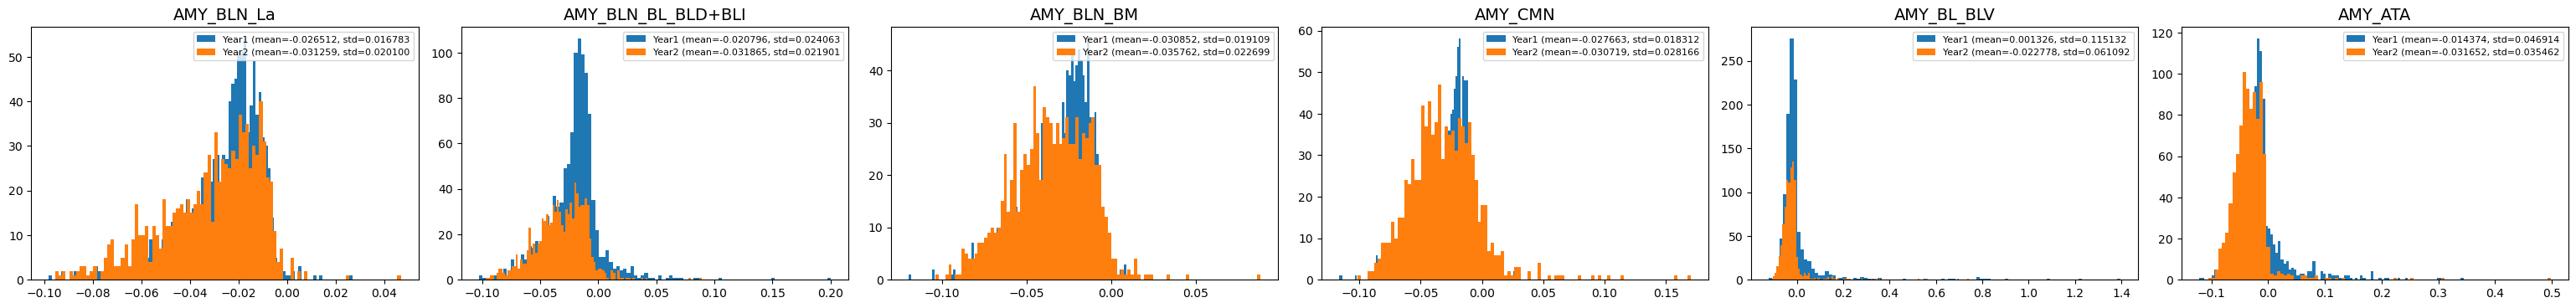

In [189]:
roi = 'Amygdala'     #options = ['HarvardOxford_Cortical', 'HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if roi == 'HarvardOxford_Cortical': 
    y1_attr_score_dir = os.path.join(*[base_dir, 'after1y' , "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
    y2_attr_score_dir = os.path.join(*[base_dir, 'after2y' , "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
elif roi == 'HarvardOxford_Subcortical': 
    y1_attr_score_dir = os.path.join(*[base_dir, 'after1y', "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
    y2_attr_score_dir = os.path.join(*[base_dir, 'after2y', "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif roi == 'ReinforcementLearning':
    y1_attr_score_dir = os.path.join(*[base_dir, 'after1y', "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
    y2_attr_score_dir = os.path.join(*[base_dir, 'after2y', "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif roi == "Amygdala": 
    y1_attr_score_dir = os.path.join(*[base_dir, 'after1y', "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
    y2_attr_score_dir = os.path.join(*[base_dir, 'after2y', "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

y1_attr_score = pd.read_csv(y1_attr_score_dir)
y2_attr_score = pd.read_csv(y2_attr_score_dir)
y1_cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label",'Amygdala', 'after1y_case_cluster.csv'])
y2_cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label",'Amygdala', 'after2y_case_cluster.csv'])
y1_cluster_label = pd.read_csv(y1_cluster_label_dir)
y2_cluster_label = pd.read_csv(y2_cluster_label_dir)
y1_cluster_label = y1_cluster_label[['subjectkey', "cluster_label"]]
y2_cluster_label = y2_cluster_label[['subjectkey', "cluster_label"]]

# merge 
y1_df_merge = pd.merge(y1_attr_score, y1_cluster_label, on='subjectkey', how='inner')
y2_df_merge = pd.merge(y2_attr_score, y2_cluster_label, on='subjectkey', how='inner')


# plotting
y1_significant_num = 0 
for i, ROI in enumerate(y1_attr_score.keys()[1:]): 
    if np.sum(y1_attr_score[ROI].values) == 0:
        pass 
    else: 
        y1_significant_num += 1 
y2_significant_num = 0 
for i, ROI in enumerate(y2_attr_score.keys()[1:]): 
    if np.sum(y2_attr_score[ROI].values) == 0:
        pass 
    else: 
        y2_significant_num += 1 
assert y1_significant_num == y2_significant_num

        
#nrows = ncols = int(np.sqrt(y1_significant_num) + 1) 
nrows = ncols = 7
plt.figure(figsize=(36, 24))
index = 1
for y1_ROI, y2_ROI in zip(y1_attr_score.keys()[1:], y1_attr_score.keys()[1:]): 
    assert y1_ROI == y2_ROI 
    ROI = y1_ROI
    if np.sum(y1_attr_score[ROI].values) == 0 and np.sum(y2_attr_score[ROI].values) == 0: 
        pass
    else:
        plt.subplot(nrows, ncols, index)
        y1_value = y1_attr_score[ROI].values
        y2_value = y2_attr_score[ROI].values
        plt.hist(y1_value, bins=100, label='Year1 (mean={:2f}, std={:2f}'.format(np.mean(y1_attr_score[ROI]), np.std(y1_attr_score[ROI])))
        plt.hist(y2_value, bins=100, label='Year2 (mean={:2f}, std={:2f}'.format(np.mean(y2_attr_score[ROI]), np.std(y2_attr_score[ROI])))
        plt.legend(loc='upper right', fontsize=8)
        plt.title("{}".format(ROI), fontsize=14)
        index += 1

plt.tight_layout()
plt.show()

## Case vs. Control

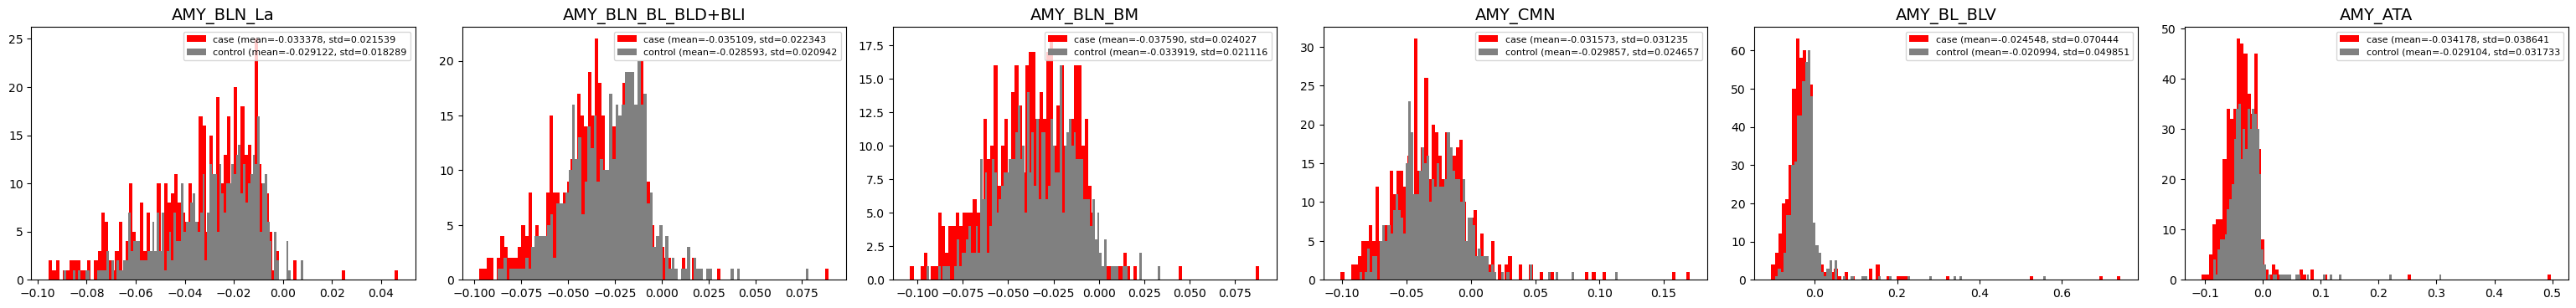

In [209]:
from scipy.stats import ttest_ind
year = 'after2y'        #options = ['after1y', 'after2y'] 
roi = "Amygdala"      #options = ['HarvardOxford_Cortical', 'HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if roi == 'HarvardOxford_Cortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
elif roi == 'HarvardOxford_Subcortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif roi == 'ReinforcementLearning':
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif roi == "Amygdala": 
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

attr_score = pd.read_csv(attr_score_dir)
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label", roi, '%s_case_cluster.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]

# merge 
df_merge = pd.merge(attr_score, cluster_label, on='subjectkey', how='left')
df_merge['cluster_label'] = np.where(np.isnan(df_merge['cluster_label']) == True, 'control', df_merge['cluster_label'])

# plotting
#nrows = ncols = int(np.sqrt(len(df_merge.keys()[1:])) + 1 )
nrows = ncols = 7
plt.figure(figsize=(36, 24))
index = 1
for ROI in df_merge.keys()[1:-1]: 
    if np.sum(df_merge[ROI].values) == 0: 
        pass
    else:
        plt.subplot(nrows, ncols, index)
        label_0_value = df_merge[df_merge['cluster_label'] == '0.0'][ROI].values
        label_1_value = df_merge[df_merge['cluster_label'] == '1.0'][ROI].values
        case_value = np.concatenate([label_0_value, label_1_value])
        control_value = df_merge[df_merge['cluster_label'] == 'control'][ROI].values
        plt.hist(case_value, bins=100, label='case (mean={:2f}, std={:2f}'.format(np.mean(case_value),np.std(case_value)), color='red')
        plt.hist(control_value, bins=100, label='control (mean={:2f}, std={:2f}'.format(np.mean(control_value),np.std(control_value)), color='gray')
        plt.legend(loc='upper right', fontsize=8)
        plt.title("{}".format(ROI), fontsize=14)
        index += 1
plt.tight_layout()
plt.show()

## Cluster

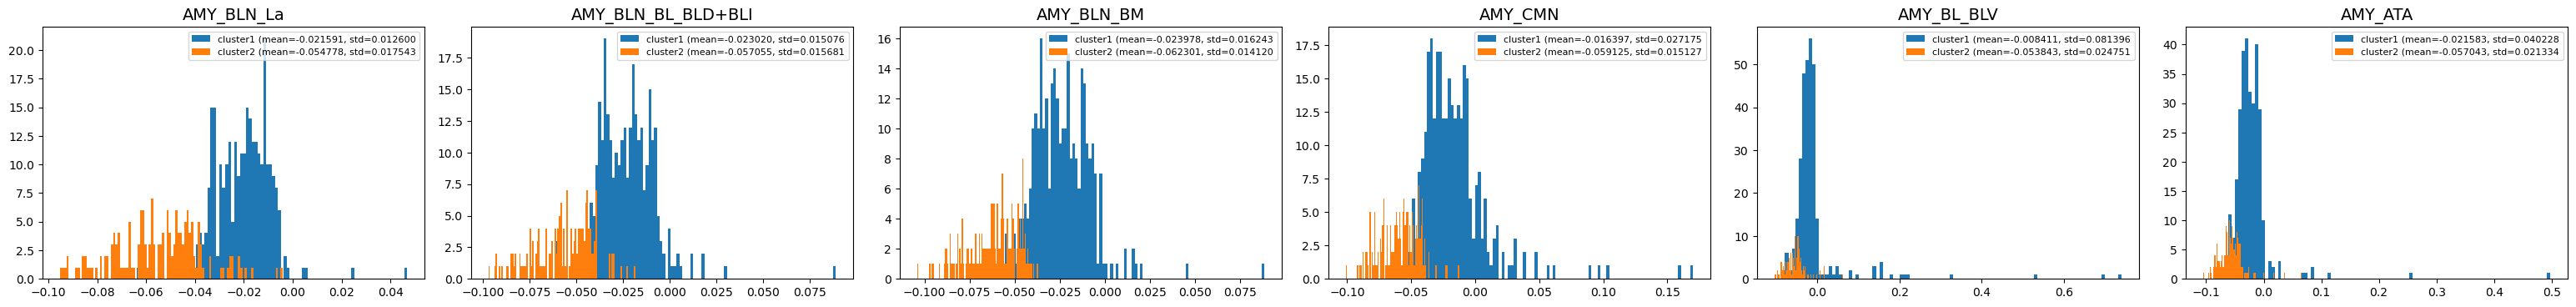

In [221]:
from scipy.stats import ttest_ind
year = 'after2y'        #options = ['after1y', 'after2y'] 
roi = 'Amygdala'    #options = ['HarvardOxford_Cortical', 'HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if roi == 'HarvardOxford_Cortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
elif roi == 'HarvardOxford_Subcortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif roi == 'ReinforcementLearning':
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif roi == "Amygdala": 
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

attr_score = pd.read_csv(attr_score_dir)
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label", roi, '%s_case_cluster.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]

# merge 
df_merge = pd.merge(attr_score, cluster_label, on='subjectkey', how='left')

# plotting
#nrows = ncols = int(np.sqrt(len(df_merge.keys()[1:])) + 1 )
plt.figure(figsize=(36, 24))
nrows = ncols = 7
index = 1

colors = ['cluster0', 'cluster1']
for ROI in df_merge.keys()[1:-1]: 
    if np.sum(df_merge[ROI].values) == 0: 
        pass
    else:
        plt.subplot(nrows, ncols, index)
        label_0_value = df_merge[df_merge['cluster_label'] == 0][ROI].values
        label_1_value = df_merge[df_merge['cluster_label'] == 1][ROI].values
        value = [label_0_value, label_1_value]
    
        plt.hist(label_0_value, bins=100, label='cluster1 (mean={:2f}, std={:2f}'.format(np.mean(label_0_value),np.std(label_0_value)))
        plt.hist(label_1_value, bins=100, label='cluster2 (mean={:2f}, std={:2f}'.format(np.mean(label_1_value),np.std(label_1_value)))
        plt.legend(loc='upper right', fontsize=8)
        plt.title("{}".format(ROI), fontsize=14)
        index += 1 

plt.tight_layout()
plt.show()

In [51]:
from ipywidgets import interact 

def standardize(x): 
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean) / std 

def get_attr_mask(x, criterion_factor=0):
    x = standardize(x)
    x = np.where(x >= np.mean(x) + criterion_factor * np.std(x), 1, 0)
    return x 

def make_mean_attr_all_partition(subject_list): 
    mean_attr = []
    
    for subj in subject_list:
        attr = np.load(subj)
        # standardization
        attr = (attr - np.mean(attr)) / np.std(attr)
        attr = np.expand_dims(attr, axis=0)
        mean_attr.append(attr)
    
    mean_attr = np.concatenate(mean_attr, axis=0)
    mean_attr = np.mean(mean_attr, axis=0, keepdims=True)
    return np.squeeze(mean_attr, axis=0)


OBESITY_attr_dir = [] 
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition0')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition1')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition2')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition3')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition4')
template_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/interpretation/ABCD/MNI'

# phenotype_data
year = 'after1y'
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label",'Amygdala', '%s_case_cluster.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]


# get every partition data
OBESITY_subject_list = []
OBESITY_subject_img_list = []
for OBESITY_attr_dir_partition in OBESITY_attr_dir:
    for file in  glob.glob(OBESITY_attr_dir_partition + '/*'): 
        OBESITY_subject_list.append(os.path.split(file)[-1][:-4])
        OBESITY_subject_img_list.append(file)
OBESITY_img_df = pd.DataFrame({'subjectkey': OBESITY_subject_list, 'image_files': OBESITY_subject_img_list})

# split sub-cluster data 
target_img_df = pd.merge(cluster_label, OBESITY_img_df, how='inner', on='subjectkey')
cluster0_img_list = target_img_df[target_img_df['cluster_label'] == 0]['image_files']
cluster1_img_list = target_img_df[target_img_df['cluster_label'] == 1]['image_files']

cluster0_attr =  make_mean_attr_all_partition(cluster0_img_list)
cluster1_attr =  make_mean_attr_all_partition(cluster1_img_list)
template_img = nib.load(os.path.join(template_dir, "MNI152_T1_1mm_Brain.nii.gz"))
template_img = np.array(template_img.dataobj)


# resize image to the size of attr 
transform = Compose([AddChannel(), Resize((128, 128, 128))])
template_img = transform(template_img)


# masking amygdala 
Amygdala_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Amygdala_v1.0.3/CIT168_iAmyNuc_1mm_MNI.nii.gz"
mask = nib.load(Amygdala_mask) 
mask = np.array(mask.dataobj)
mask = np.where(mask != 0, 1, 0)
mask_img = transform(mask).squeeze(0)

# applying mask 
cluster0_attr_masked = cluster0_attr * mask_img
cluster1_attr_masked = cluster1_attr * mask_img



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [52]:
"""
masked = get_attr_mask(cluster0_attr - cluster1_attr, criterion_factor=2)
reverse_masked = get_attr_mask(cluster1_attr - cluster0_attr, criterion_factor=2)

def sagittal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,x,:,:], cmap='gray')
    plt.imshow(masked[x,:,:], cmap='Reds',  alpha=0.5)
    plt.imshow(reverse_masked[x,:,:], cmap='Blues',  alpha=0.5)
    plt.show()

def coronal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,:,x], cmap='gray')
    plt.imshow(masked[:,:,x], cmap='Reds', alpha=0.5)
    plt.imshow(reverse_masked[:,:,x], cmap='Blues',  alpha=0.5)
    plt.show()

def horizontal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,x,:], cmap='gray')
    plt.imshow(masked[:,x,:], cmap='Reds',  alpha=0.5)
    plt.imshow(reverse_masked[:,x,:], cmap='Blues',  alpha=0.5)
    plt.show()
"""

"""
def sagittal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,x,:,:], cmap='gray')
    plt.imshow(cluster0_attr[x,:,:], cmap='Reds', alpha=0.5)
    plt.imshow(cluster1_attr[x,:,:], cmap='Blues', alpha=0.45)
    plt.show()

def coronal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,:,x], cmap='gray')
    plt.imshow(cluster0_attr[:,:,x], cmap='Reds', alpha=0.5)
    plt.imshow(cluster1_attr[:,:,x], cmap='Blues', alpha=0.45)
    plt.show()

def horizontal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,x,:], cmap='gray')
    plt.imshow(cluster0_attr[:,x,:], cmap='Reds', alpha=0.5)
    plt.imshow(cluster1_attr[:,x,:], cmap='Blues', alpha=0.45)
    plt.show()
"""
def sagittal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,x,:,:], cmap='gray')
    plt.imshow((cluster0_attr_masked - cluster1_attr_masked)[x,:,:], cmap='Reds', alpha=0.5, vmin=0, vmax=np.max(cluster0_attr_masked - cluster1_attr_masked))
    plt.colorbar()
    plt.show()

def coronal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,:,x], cmap='gray')
    plt.imshow((cluster0_attr_masked - cluster1_attr_masked)[:,:,x], cmap='Reds', alpha=0.5, vmin=0, vmax=np.max(cluster0_attr_masked - cluster1_attr_masked))
    plt.colorbar()
    plt.show()

def horizontal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,x,:], cmap='gray')
    plt.imshow((cluster0_attr_masked - cluster1_attr_masked)[:,x,:], cmap='Reds', alpha=0.5, vmin=0, vmax=np.max(cluster0_attr_masked - cluster1_attr_masked))
    plt.colorbar()
    plt.show()

interact(sagittal_view, x=(0,127))
interact(coronal_view, x=(0,127))
interact(horizontal_view, x=(0,127))

interactive(children=(IntSlider(value=63, description='x', max=127), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=63, description='x', max=127), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=63, description='x', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.horizontal_view(x)>

## Case-case

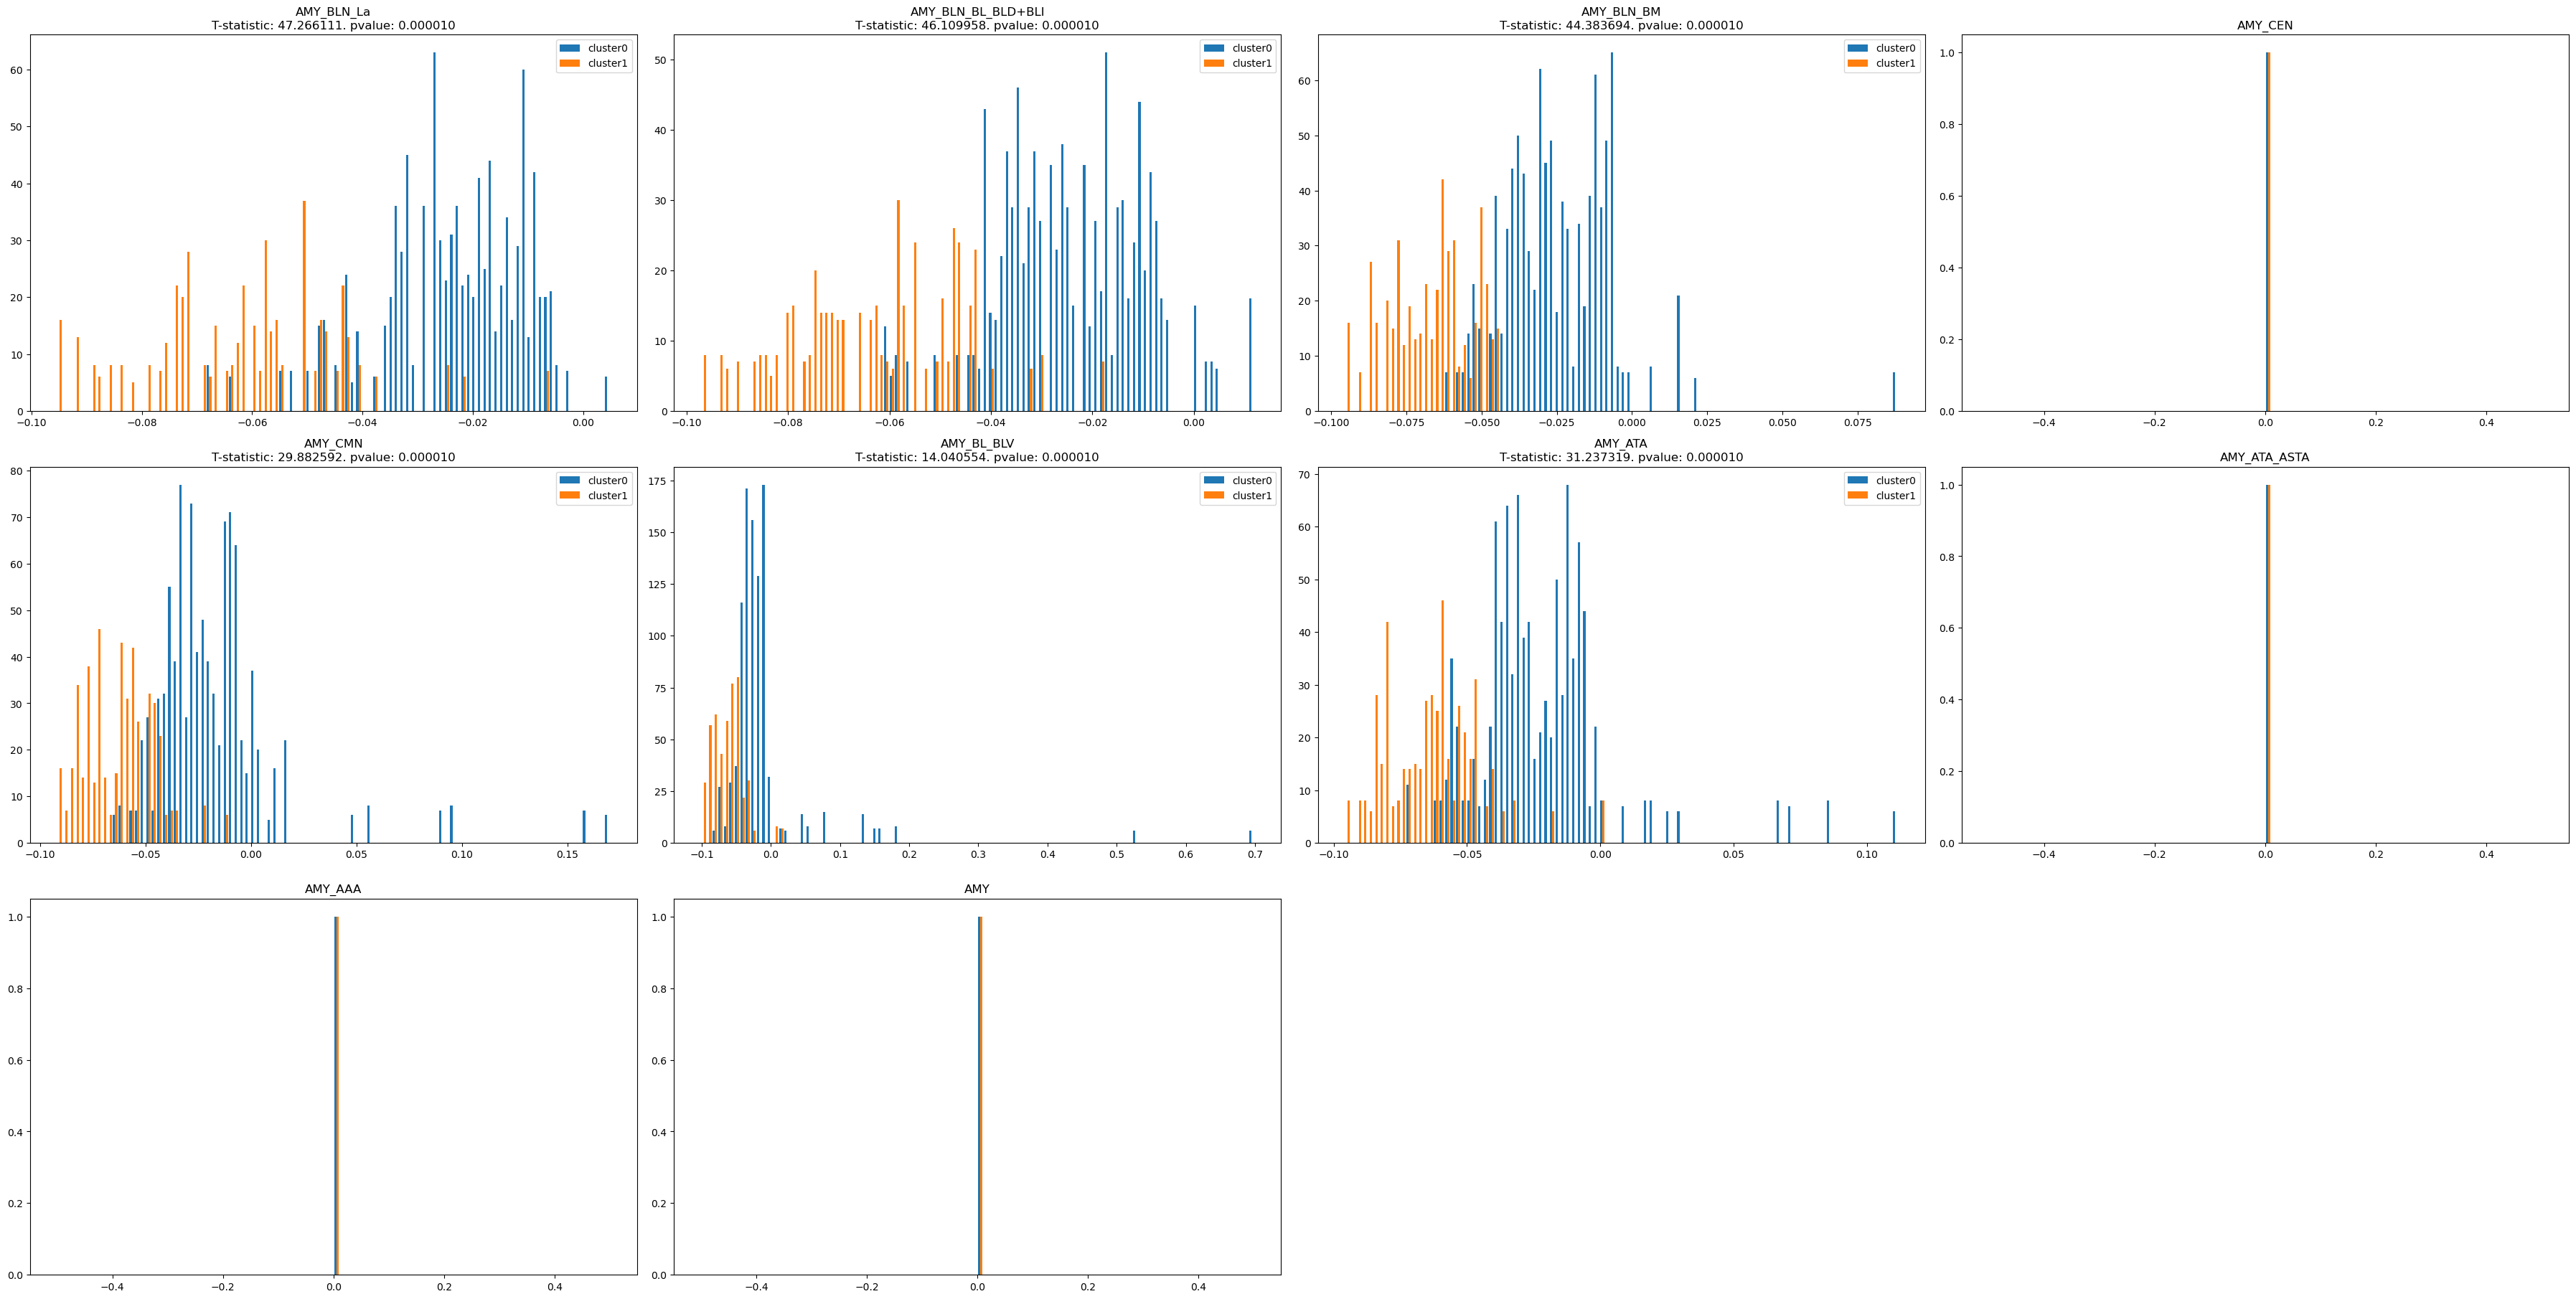

In [151]:
from scipy.stats import ttest_ind
year = 'after2y'        #options = ['after1y', 'after2y'] 
roi = "Amygdala"      #options = ['HarvardOxford_Cortical','HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]
development = 'case_case'

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if roi == 'HarvardOxford_Cortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
elif roi == 'HarvardOxford_Subcortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif roi == 'ReinforcementLearning':
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif roi == "Amygdala": 
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

attr_score = pd.read_csv(attr_score_dir)
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity/%s" % development, roi, '%s_case_cluster_delta.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]

# merge 
df_merge = pd.merge(attr_score, cluster_label, on='subjectkey', how='left')

# plotting
nrows = ncols = int(np.sqrt(len(df_merge.keys()[1:])) + 1 )
plt.figure(figsize=(36, 24))
colors = ['cluster0', 'cluster1']
for i, ROI in enumerate(df_merge.keys()[:-1][1:]): 
    plt.subplot(nrows, ncols, i+1)
    if np.sum(df_merge[ROI].values) == 0: 
        value = [np.array([0]), np.array([0])]
        plt.hist(value, bins=100, label=colors)
        plt.title("{}".format(ROI))
    else:
        label_0_value = df_merge[df_merge['cluster_label'] == 0][ROI].values
        label_1_value = df_merge[df_merge['cluster_label'] == 1][ROI].values
        value = [label_0_value, label_1_value]
        ttest_res = ttest_ind(label_0_value, label_1_value , permutations=100000)
        plt.hist(value, bins=100, label=colors)
        plt.legend()
        plt.title("{}\nT-statistic: {:2f}. pvalue: {:2f}".format(ROI,ttest_res.statistic, ttest_res.pvalue))
        #plt.title("{}\nMean: {:2f}. Std: {:2f}".format(ROI,np.mean(df_merge[ROI]), np.std(df_merge[ROI])))

plt.tight_layout()
plt.show()

In [144]:
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity/%s" % development, roi, '%s_case_cluster_delta.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label['cluster_label'] = cluster_label['cluster_label'].values - 1
cluster_label['cluster_label'] = np.where(cluster_label['cluster_label'].values == -1, 1, cluster_label['cluster_label'].values)
cluster_label.to_csv(os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity/%s" % development, roi, '%s_case_cluster_delta.csv' % year]), index=False)

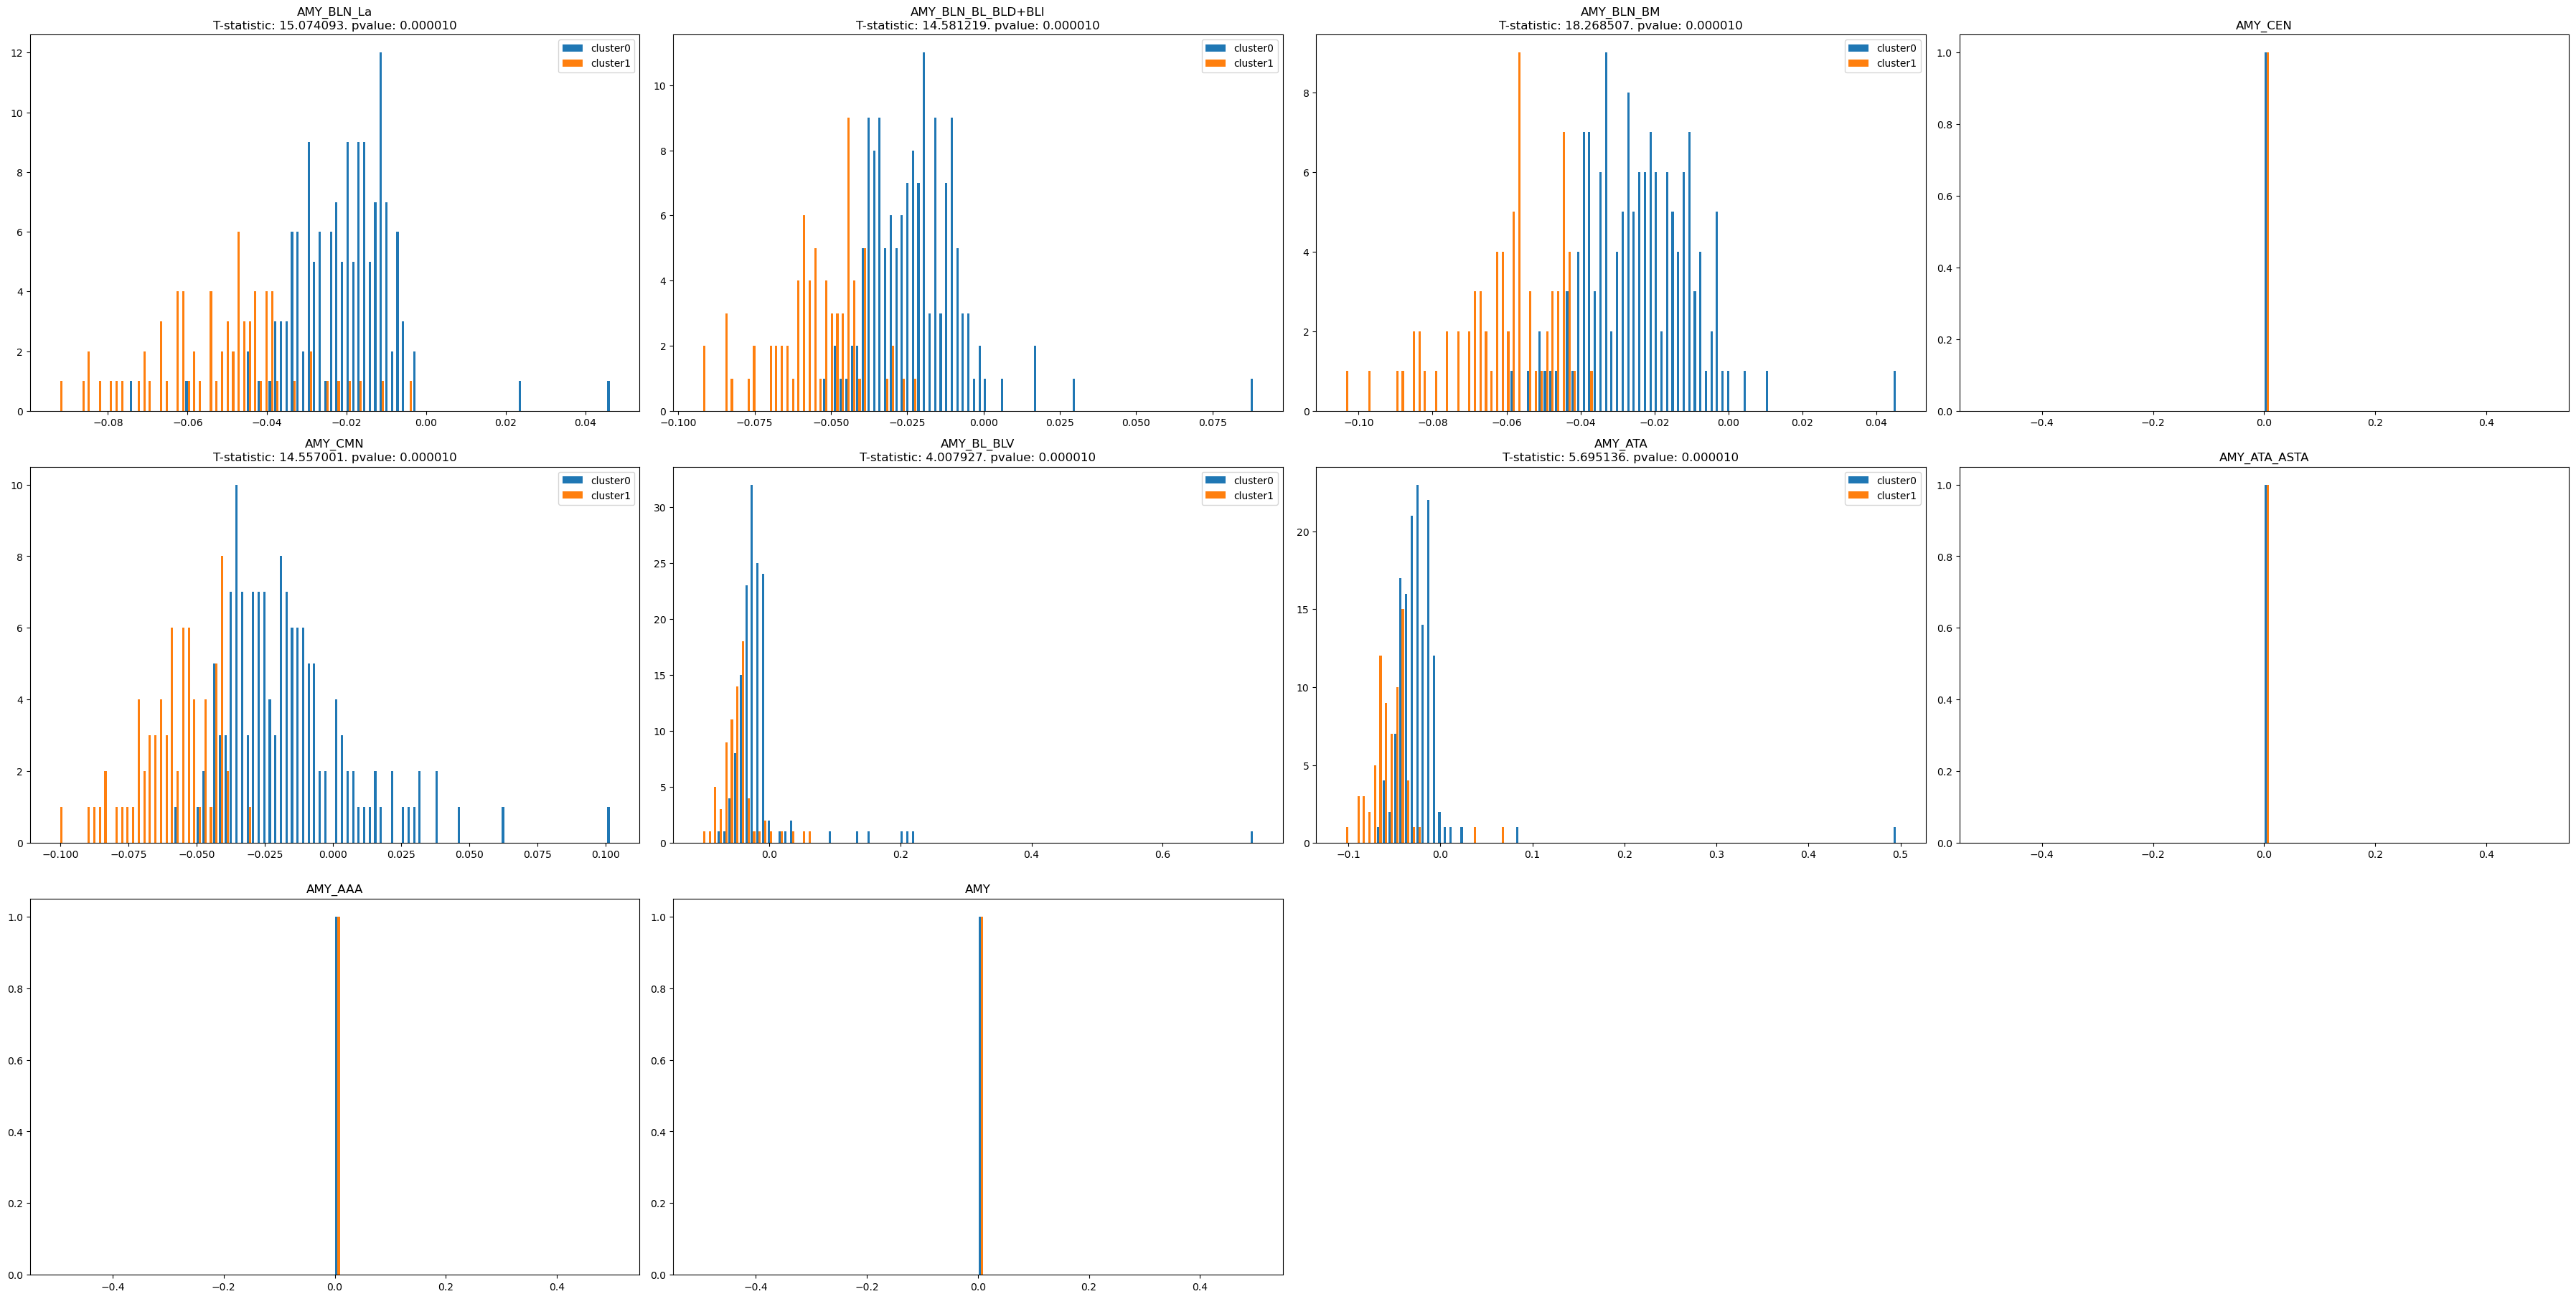

In [77]:
from scipy.stats import ttest_ind
year = 'after2y'        #options = ['after1y', 'after2y'] 
roi = "Amygdala"      #options = ['HarvardOxford_Cortical','HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]
development = 'control_case'

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if roi == 'HarvardOxford_Cortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
elif roi == 'HarvardOxford_Subcortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif roi == 'ReinforcementLearning':
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif roi == "Amygdala": 
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

attr_score = pd.read_csv(attr_score_dir)
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity/%s" % development, roi, '%s_case_cluster.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]

# merge 
df_merge = pd.merge(attr_score, cluster_label, on='subjectkey', how='left')

# plotting
nrows = ncols = int(np.sqrt(len(df_merge.keys()[1:])) + 1 )
plt.figure(figsize=(36, 24))
colors = ['cluster0', 'cluster1']
for i, ROI in enumerate(df_merge.keys()[:-1][1:]): 
    plt.subplot(nrows, ncols, i+1)
    if np.sum(df_merge[ROI].values) == 0: 
        value = [np.array([0]), np.array([0])]
        plt.hist(value, bins=100, label=colors)
        plt.title("{}".format(ROI))
    else:
        label_0_value = df_merge[df_merge['cluster_label'] == 0][ROI].values
        label_1_value = df_merge[df_merge['cluster_label'] == 1][ROI].values
        value = [label_0_value, label_1_value]
        ttest_res = ttest_ind(label_0_value, label_1_value , permutations=100000)
        plt.hist(value, bins=100, label=colors)
        plt.legend()
        plt.title("{}\nT-statistic: {:2f}. pvalue: {:2f}".format(ROI,ttest_res.statistic, ttest_res.pvalue))
        #plt.title("{}\nMean: {:2f}. Std: {:2f}".format(ROI,np.mean(df_merge[ROI]), np.std(df_merge[ROI])))

plt.tight_layout()
plt.show()

In [78]:
from scipy.stats import ttest_ind
year = 'after2y'        #options = ['after1y', 'after2y'] 
roi = "Amygdala"      #options = ['HarvardOxford_Cortical','HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]
development = 'case_control'

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if roi == 'HarvardOxford_Cortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
elif roi == 'HarvardOxford_Subcortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif roi == 'ReinforcementLearning':
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif roi == "Amygdala": 
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

attr_score = pd.read_csv(attr_score_dir)
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity/%s" % development, roi, '%s_case_cluster.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]

# merge 
df_merge = pd.merge(attr_score, cluster_label, on='subjectkey', how='left')

# plotting
nrows = ncols = int(np.sqrt(len(df_merge.keys()[1:])) + 1 )
plt.figure(figsize=(36, 24))
colors = ['cluster0', 'cluster1']
for i, ROI in enumerate(df_merge.keys()[:-1][1:]): 
    plt.subplot(nrows, ncols, i+1)
    if np.sum(df_merge[ROI].values) == 0: 
        value = [np.array([0]), np.array([0])]
        plt.hist(value, bins=100, label=colors)
        plt.title("{}".format(ROI))
    else:
        label_0_value = df_merge[df_merge['cluster_label'] == 0][ROI].values
        label_1_value = df_merge[df_merge['cluster_label'] == 1][ROI].values
        value = [label_0_value, label_1_value]
        ttest_res = ttest_ind(label_0_value, label_1_value , permutations=100000)
        plt.hist(value, bins=100, label=colors)
        plt.legend()
        plt.title("{}\nT-statistic: {:2f}. pvalue: {:2f}".format(ROI,ttest_res.statistic, ttest_res.pvalue))
        #plt.title("{}\nMean: {:2f}. Std: {:2f}".format(ROI,np.mean(df_merge[ROI]), np.std(df_merge[ROI])))

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity/case_control/Amygdala/after2y_case_cluster.csv'

# Pearson's r test with significant cluster analysis

In [174]:
import scipy

target_list = ['worryauto', 'cbcl_dsm_anxiety', 'cbcl_anxiety']
year_list = ['after1y', 'after2y', 'after2y']
delta_list = [False, True, True]
atlas = 'Amygdala'

# setting statistic 
def statistic(x, y):
    return scipy.stats.pearsonr(x, y).statistic

# getting attribution score 
base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if atlas == 'HarvardOxford_Subcortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif atlas == 'ReinforcementLearning':
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif atlas == "Amygdala": 
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

for (year, target, delta) in zip(year_list, target_list, delta_list):
    # loading attribution score data and filtering case subject
    attr_score = pd.read_csv(attr_score_dir)
    cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label", atlas, '%s_case_cluster.csv' % year])
    cluster_label = pd.read_csv(cluster_label_dir)
    cluster_label = cluster_label[['subjectkey', "cluster_label"]]
    df_merge = pd.merge(attr_score, cluster_label, on='subjectkey', how='left')
    
    
    # loading phenotype data and filtering case subjects 
    pheno = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD Release4.0 Tabular dataset.csv')
    for i in range(len(pheno)): 
        pheno['subjectkey'][i] = pheno['subjectkey'][i].replace('_','')
    if year == 'after1y': 
        followup_year = "1_year_follow_up_y_arm_1"
    elif year =='after2y':
        followup_year = '2_year_follow_up_y_arm_1' # choices = ["1_year_follow_up_y_arm_1", "2_year_follow_up_y_arm_1"] 

    # followup_year data 
    pheno_filtered = pheno[pheno['eventname'] == followup_year]
    pheno_filtered = pd.merge(pheno_filtered, df_merge, how='inner', on='subjectkey')
    if target == 'worryauto': 
        pheno_filtered = pheno_filtered[pheno_filtered['euro'] == 1]

    # baseline_year data 
    pheno_filtered_baseline = pheno[pheno['eventname'] == 'baseline_year_1_arm_1']
    pheno_filtered_baseline = pd.merge(pheno_filtered_baseline, df_merge, how='inner', on='subjectkey')


    # atlas names 
    roi_list = list(df_merge.keys()[1:-1])
    
    # statistics test 
    result_pvalue = []
    for roi in roi_list: 
        pheno_tmp = pheno_filtered[[roi, target]]
        pheno_tmp = pheno_tmp.dropna(axis=0)
        if np.sum(pheno_tmp[roi]) != 0:
            result = scipy.stats.permutation_test((pheno_tmp[roi], pheno_tmp[target]), statistic, vectorized=False, n_resamples=1e+5,
                            permutation_type='pairings')
            result_pvalue.append(result.pvalue)
        else: 
            result_pvalue.append(None)
    result_df = pd.DataFrame({'ROI': roi_list, 'result_pvalue': result_pvalue})
    print('Target: {}. Year: {}. Delta: {}'.format(target, year, delta))
    print(result_df)
    
    if delta:
        result_delta_pvalue = []
        for roi in roi_list: 
            subject = pd.DataFrame({'subjectkey': pheno_filtered['subjectkey'].values})
            pheno_follow = pd.merge(pheno_filtered[['subjectkey', target]], subject, how='inner', on='subjectkey')
            pheno_follow.columns = ['subjectkey', 'follow_target']
            pheno_baseline = pd.merge(pheno_filtered_baseline[['subjectkey', target]], subject, how='inner', on='subjectkey')
            pheno_baseline.columns = ['subjectkey', 'baseline_target']
            pheno_delta = pd.merge(pheno_follow, pheno_baseline, how='inner', on='subjectkey')
            pheno_delta = pheno_delta.dropna(axis=0)
            pheno_delta['delta'] = pheno_delta['follow_target'].values - pheno_delta['baseline_target']

            pheno_delta_tmp = pd.merge(pheno_filtered[['subjectkey', roi]], pheno_delta[['subjectkey', 'delta']], how='inner', on='subjectkey')
            if np.sum(pheno_delta_tmp[roi]) != 0:
                result = scipy.stats.permutation_test((pheno_delta_tmp[roi], pheno_delta_tmp['delta']), statistic, vectorized=False, n_resamples=1e+5,
                                permutation_type='pairings')
                result_delta_pvalue.append(result.pvalue)
            else: 
                result_delta_pvalue.append(None)
        
        result_df = pd.DataFrame({'ROI': roi_list, 'result_pvalue': result_pvalue, 'result_delta_pvalue':result_delta_pvalue})
        print('Target: {}. Year: {}. Delta: {}'.format(target, year, delta))
        print(result_df)

/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_33692/3410334255.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno['subjectkey'][i] = pheno['subjectkey'][i].replace('_','')


Target: worryauto. Year: after1y. Delta: False
                  ROI  result_pvalue
0          AMY_BLN_La       0.919531
1  AMY_BLN_BL_BLD+BLI       0.703933
2          AMY_BLN_BM       0.951170
3             AMY_CEN            NaN
4             AMY_CMN       0.552214
5          AMY_BL_BLV       0.159798
6             AMY_ATA       0.042560
7        AMY_ATA_ASTA            NaN
8             AMY_AAA            NaN
9                 AMY            NaN


/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_33692/3410334255.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno['subjectkey'][i] = pheno['subjectkey'][i].replace('_','')


Target: cbcl_dsm_anxiety. Year: after2y. Delta: True
                  ROI  result_pvalue
0          AMY_BLN_La       0.723453
1  AMY_BLN_BL_BLD+BLI       0.545235
2          AMY_BLN_BM       0.276857
3             AMY_CEN            NaN
4             AMY_CMN       0.307197
5          AMY_BL_BLV       0.916851
6             AMY_ATA       0.858951
7        AMY_ATA_ASTA            NaN
8             AMY_AAA            NaN
9                 AMY            NaN


# Visualize

In [44]:
from ipywidgets import interact 

def standardize(x): 
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean) / std 

def get_attr_mask(x, criterion_factor=0):
    x = standardize(x)
    x = np.where(x >= np.mean(x) + criterion_factor * np.std(x), 1, 0)
    return x 

def make_mean_attr_all_partition(subject_list): 
    mean_attr = []
    
    for subj in subject_list:
        attr = np.load(subj)
        # standardization
        attr = (attr - np.mean(attr)) / np.std(attr)
        attr = np.expand_dims(attr, axis=0)
        mean_attr.append(attr)
    
    mean_attr = np.concatenate(mean_attr, axis=0)
    mean_attr = np.mean(mean_attr, axis=0, keepdims=True)
    return np.squeeze(mean_attr, axis=0)


OBESITY_attr_dir = [] 
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition0')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition1')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition2')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition3')
OBESITY_attr_dir.append('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/XAI/become_overweight/1year/partition4')
template_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/interpretation/ABCD/MNI'

# phenotype_data
year = 'after2y'
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label",'Amygdala', '%s_case_cluster.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]


# get every partition data
OBESITY_subject_list = []
OBESITY_subject_img_list = []
for OBESITY_attr_dir_partition in OBESITY_attr_dir:
    for file in  glob.glob(OBESITY_attr_dir_partition + '/*'): 
        OBESITY_subject_list.append(os.path.split(file)[-1][:-4])
        OBESITY_subject_img_list.append(file)
OBESITY_img_df = pd.DataFrame({'subjectkey': OBESITY_subject_list, 'image_files': OBESITY_subject_img_list})

# split sub-cluster data 
target_img_df = pd.merge(cluster_label, OBESITY_img_df, how='inner', on='subjectkey')
cluster0_img_list = target_img_df[target_img_df['cluster_label'] == 0]['image_files']
cluster1_img_list = target_img_df[target_img_df['cluster_label'] == 1]['image_files']

cluster0_attr =  make_mean_attr_all_partition(cluster0_img_list)
cluster1_attr =  make_mean_attr_all_partition(cluster1_img_list)
template_img = nib.load(os.path.join(template_dir, "MNI152_T1_1mm_Brain.nii.gz"))
template_img = np.array(template_img.dataobj)


# resize image to the size of attr 
transform = Compose([AddChannel(), Resize((128, 128, 128))])
template_img = transform(template_img)


# masking amygdala 
Amygdala_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Amygdala_v1.0.3/CIT168_iAmyNuc_1mm_MNI.nii.gz"
mask = nib.load(Amygdala_mask) 
mask = np.array(mask.dataobj)
mask = np.where(mask != 0, 1, 0)
mask_img = transform(mask).squeeze(0)

# applying mask 
cluster0_attr_masked = cluster0_attr * mask_img
cluster1_attr_masked = cluster1_attr * mask_img



/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [50]:
"""
masked = get_attr_mask(cluster0_attr - cluster1_attr, criterion_factor=2)
reverse_masked = get_attr_mask(cluster1_attr - cluster0_attr, criterion_factor=2)

def sagittal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,x,:,:], cmap='gray')
    plt.imshow(masked[x,:,:], cmap='Reds',  alpha=0.5)
    plt.imshow(reverse_masked[x,:,:], cmap='Blues',  alpha=0.5)
    plt.show()

def coronal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,:,x], cmap='gray')
    plt.imshow(masked[:,:,x], cmap='Reds', alpha=0.5)
    plt.imshow(reverse_masked[:,:,x], cmap='Blues',  alpha=0.5)
    plt.show()

def horizontal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,x,:], cmap='gray')
    plt.imshow(masked[:,x,:], cmap='Reds',  alpha=0.5)
    plt.imshow(reverse_masked[:,x,:], cmap='Blues',  alpha=0.5)
    plt.show()
"""

"""
def sagittal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,x,:,:], cmap='gray')
    plt.imshow(cluster0_attr_masked[x,:,:], cmap='Reds', alpha=0.5)
    plt.imshow(cluster1_attr_masked[x,:,:], cmap='Blues', alpha=0.45)
    plt.colorbar()
    plt.show()

def coronal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,:,x], cmap='gray')
    plt.imshow(cluster0_attr_masked[:,:,x], cmap='Reds', alpha=0.5)
    plt.imshow(cluster1_attr_masked[:,:,x], cmap='Blues', alpha=0.45)
    plt.colorbar()
    plt.show()

def horizontal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,x,:], cmap='gray')
    plt.imshow(cluster0_attr_masked[:,x,:], cmap='Reds', alpha=0.5)
    plt.imshow(cluster1_attr_masked[:,x,:], cmap='Blues', alpha=0.45)
    plt.colorbar()
    plt.show()
"""
def sagittal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,x,:,:], cmap='gray')
    plt.imshow((cluster1_attr_masked - cluster0_attr_masked)[x,:,:], cmap='Reds', alpha=0.5, vmin=0, vmax=np.max(cluster1_attr_masked - cluster0_attr_masked))
    plt.colorbar()
    plt.show()

def coronal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,:,x], cmap='gray')
    plt.imshow((cluster1_attr_masked - cluster0_attr_masked)[:,:,x], cmap='Reds', alpha=0.5, vmin=0, vmax=np.max(cluster1_attr_masked - cluster0_attr_masked))
    plt.colorbar()
    plt.show()

def horizontal_view(x,): 
    plt.figure()
    plt.imshow(template_img[0,:,x,:], cmap='gray')
    plt.imshow((cluster1_attr_masked - cluster0_attr_masked)[:,x,:], cmap='Reds', alpha=0.5, vmin=0, vmax=np.max(cluster1_attr_masked - cluster0_attr_masked))
    plt.colorbar()
    plt.show()


interact(sagittal_view, x=(0,127))
interact(coronal_view, x=(0,127))
interact(horizontal_view, x=(0,127))

interactive(children=(IntSlider(value=63, description='x', max=127), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=63, description='x', max=127), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=63, description='x', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.horizontal_view(x)>

In [32]:
pheno_BMI = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv')
pheno = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD Release4.0 Tabular dataset.csv')
pheno = pheno[pheno['eventname'] == 'baseline_year_1_arm_1'].reset_index()
for i in range(len(pheno)): 
        pheno['subjectkey'][i] = pheno['subjectkey'][i].replace('_','')


/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_2315/919001747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pheno['subjectkey'][i] = pheno['subjectkey'][i].replace('_','')


In [37]:
file_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/experiments/ML_experiments/ML_BMI_sds_baseline_phenotype.json'
with open(file_dir, 'r') as f: 
    result = json.load(f)

for model in result.keys(): 
    print(model)
    for metric in result[model].keys(): 
        print(metric)
        print(np.mean(result[model][metric]))
        print(np.std(result[model][metric]))

ElasticNet
MAE
0.8706533753234158
0.0019736298667763336
MSE
1.1721948937314814
0.003397829003904457
R2
0.0887818591650064
0.0013880364759806445
LinearSVM
MAE
0.8693725942579151
0.002025393104260572
MSE
1.1797203046144507
0.004136915874194363
R2
0.08293314457069512
0.0017134502948117562
RbfSVM
MAE
0.8794613897327077
0.0021719477989497
MSE
1.2106577025178284
0.003923777099545307
R2
0.058882598266366215
0.001872978495139639


In [74]:
import scipy 
year1_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score/after1y/CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv'
case1_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv'
year2_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score/after2y/CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv'
case2_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_2years_become_overweight_10PS_stratified_partitioned_5fold.csv'
year1 = pd.read_csv(year1_dir)
case1 = pd.read_csv(case1_dir)
year2 = pd.read_csv(year2_dir)
case2 = pd.read_csv(case2_dir)


case1 = case1[['subjectkey', 'become_overweight']].dropna(axis=0).reset_index()
case1 = case1[case1['become_overweight'] == 1].reset_index()
case2 = case2[['subjectkey', 'become_overweight']].dropna(axis=0).reset_index()
case2 = case2[case2['become_overweight'] == 1].reset_index()
year1_case = pd.merge(year1, case1[['subjectkey']], how='inner', on='subjectkey') 
year2_case = pd.merge(year2, case2[['subjectkey']], how='inner', on='subjectkey') 
merged_subject_list = pd.merge(year1_case[['subjectkey']], year2_case[['subjectkey']], how='inner', on='subjectkey')


# pearson correlation 
for ROI in year2_case.keys()[1:]: 
    year1_score = pd.merge(merged_subject_list[['subjectkey']], year1_case, how='inner', on='subjectkey')
    year2_score = pd.merge(merged_subject_list[['subjectkey']], year2_case, how='inner', on='subjectkey')
    year1_score = year1_score[ROI].values 
    year2_score = year2_score[ROI].values 
    print(scipy.stats.pearsonr(year1_score, year2_score).statistic)



0.19820995530358393
0.22577524070807595
0.23265773298798792
nan
0.21398772609204808
0.10755608813130604
0.11144005427030634
nan
nan
nan


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## Checking the number of overweight and obesity in each cluster 

In [106]:
year = 'after1y'        #options = ['after1y', 'after2y'] 
roi = "Amygdala"      #options = ['HarvardOxford_Cortical','HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if roi == 'HarvardOxford_Cortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
elif roi == 'HarvardOxford_Subcortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif roi == 'ReinforcementLearning':
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif roi == "Amygdala": 
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

attr_score = pd.read_csv(attr_score_dir)
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label", roi, '%s_case_cluster.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]

if year == 'after1y': 
    status_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD_phenotype_total_1years_revised_tmp.csv'
elif year == 'after2y': 
    status_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD_phenotype_total_2years_revised_tmp.csv'

status = pd.read_csv(status_dir)
if year == 'after1y': 
    status = status[['subjectkey', "BMI_status_1year"]]
elif year == 'after2y': 
    status = status[['subjectkey', "BMI_status_2year"]]


status_cluster = pd.merge(cluster_label, status, how='inner',on='subjectkey')

cluster0_overweight = [] 
cluster1_overweight = [] 
cluster0_obesity = [] 
cluster1_obesity = []
other = [] 

for i in range(len(status_cluster)):
    if year == 'after1y': 
        status_target = "BMI_status_1year"
    elif year == 'after2y': 
        status_target = "BMI_status_2year"
    
    if status_cluster['cluster_label'][i] == 0 and status_cluster[status_target][i] == 'overweight': 
        cluster0_overweight.append(status_cluster['subjectkey'][i]) 
    elif status_cluster['cluster_label'][i] == 1 and status_cluster[status_target][i] == 'overweight': 
        cluster1_overweight.append(status_cluster['subjectkey'][i]) 
    elif status_cluster['cluster_label'][i] == 0 and status_cluster[status_target][i] == 'obesity': 
        cluster0_obesity.append(status_cluster['subjectkey'][i]) 
    elif status_cluster['cluster_label'][i] == 1 and status_cluster[status_target][i] == 'obesity': 
        cluster1_obesity.append(status_cluster['subjectkey'][i]) 
    else: 
        other.append(status_cluster[status_target][i])

print(len(cluster0_overweight))
print(len(cluster1_overweight))
print(len(cluster0_obesity))
print(len(cluster1_obesity))

345
112
56
22


## Checking the number of male and female in each cluster 

In [127]:
year = 'after2y'        #options = ['after1y', 'after2y'] 
roi = "Amygdala"      #options = ['HarvardOxford_Cortical','HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
if roi == 'HarvardOxford_Cortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
elif roi == 'HarvardOxford_Subcortical': 
    attr_score_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
elif roi == 'ReinforcementLearning':
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
elif roi == "Amygdala": 
    attr_score_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

attr_score = pd.read_csv(attr_score_dir)
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label", roi, '%s_case_cluster.csv' % year])
cluster_label = pd.read_csv(cluster_label_dir)
cluster_label = cluster_label[['subjectkey', "cluster_label"]]


phenotype_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD Release4.0 Tabular dataset.csv'
phenotype = pd.read_csv(phenotype_dir)
phenotype = phenotype[phenotype['eventname'] == 'baseline_year_1_arm_1']
phenotype = phenotype[['subjectkey', 'sex']]
for i in range(len(phenotype)): 
    phenotype['subjectkey'].values[i] = phenotype['subjectkey'].values[i].replace('_', '')



status_cluster = pd.merge(cluster_label, phenotype, how='inner',on='subjectkey')

cluster0_male = [] 
cluster0_female = [] 
cluster1_male = [] 
cluster1_female = []
other = [] 

for i in range(len(status_cluster)):
    
    if status_cluster['cluster_label'][i] == 0 and status_cluster['sex'][i] == 'M': 
        cluster0_male.append(status_cluster['subjectkey'][i]) 
    elif status_cluster['cluster_label'][i] == 1 and status_cluster['sex'][i] == 'M': 
        cluster1_male.append(status_cluster['subjectkey'][i]) 
    elif status_cluster['cluster_label'][i] == 0 and status_cluster['sex'][i] == 'F': 
        cluster0_female.append(status_cluster['subjectkey'][i]) 
    elif status_cluster['cluster_label'][i] == 1 and status_cluster['sex'][i] == 'F': 
        cluster1_female.append(status_cluster['subjectkey'][i]) 
    else: 
        other.append(status_cluster['sex'][i])

print(len(cluster0_male))
print(len(cluster0_female))
print(len(cluster1_male))
print(len(cluster1_female))

168
137
81
87


In [244]:
orig_pheno_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/ABCD_phenotype_total_for_pretraining_1y_after_become_overweight_10PS_stratified_5fold.csv'
new_pheno_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/mh_p_ksads_ss.csv'
orig_pheno = pd.read_csv(orig_pheno_dir)
new_pheno = pd.read_csv(new_pheno_dir)

new_pheno = new_pheno[new_pheno['eventname'] == "baseline_year_1_arm_1"]
for i in range(len(new_pheno)): 
        new_pheno['src_subject_id'].values[i] = new_pheno['src_subject_id'].values[i].replace('_','')


new_pheno = new_pheno[['src_subject_id', 'ksads_1_842_p', 'ksads_14_853_p']]
new_pheno.columns = ['subjectkey', 'MDD', 'ADHD']

orig_pheno = orig_pheno.drop(['MDD','ADHD'], axis=1)
df = pd.merge(orig_pheno, new_pheno, on='subjectkey', how='inner')

#df.to_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/ABCD_phenotype_total_for_pretraining_1y_after_become_overweight_10PS_stratified_5fold.csv', index=False)

In [245]:
df['MDD'].value_counts()

0.0      11064
1.0        284
888.0       11
Name: MDD, dtype: int64

In [246]:
df.to_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/ABCD_phenotype_total_for_pretraining_1y_after_become_overweight_10PS_stratified_5fold.csv', index=False)


In [247]:
new_pheno_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/mh_p_ksads_ss.csv'
new_pheno = pd.read_csv(new_pheno_dir)

In [254]:
new_pheno[['ksads_14_856_p']]

,ksads_14_856_p
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
48492,NaN
48493,NaN
48494,NaN
48495,NaN


In [347]:
import scipy

l_name = 'lh_insula_meancurv._.3'
r_name = 'rh_insula_meancurv._.4'
roi_name = 'Insular Cortex'

## load attr score 
attr_score_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score/after2y/HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"
attr_score = pd.read_csv(attr_score_dir)

## filtering case subject from attr_score 
cluster_label_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label", 'HarvardOxford_Cortical', 'after2y_case_cluster.csv' ])
cluster_label = pd.read_csv(cluster_label_dir)
#attr_score = pd.merge(attr_score, cluster_label['subjectkey'], how='inner', on='subjectkey')

## load freesurfer result
freesurfer_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/ML/mor.some.qc.desikan.csv'
freesurfer = pd.read_csv(freesurfer_dir)
L_roi = freesurfer[['subjectkey', l_name]]
for i in range(len(L_roi)): 
        L_roi['subjectkey'][i] = L_roi['subjectkey'][i].replace('_','')
R_roi = freesurfer[['subjectkey', r_name]]
for i in range(len(R_roi)): 
        R_roi['subjectkey'][i] = R_roi['subjectkey'][i].replace('_','')



## merge data frame 
tmp = pd.merge(attr_score, L_roi, how='inner', on='subjectkey')
tmp = pd.merge(tmp, R_roi, how='inner', on='subjectkey')


## run 
check = tmp[l_name].values + tmp[r_name].values
#check = (check - np.mean(check)) / len(check)
scipy.stats.pearsonr(tmp[roi_name].values,check)

/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_2315/882825116.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L_roi['subjectkey'][i] = L_roi['subjectkey'][i].replace('_','')
/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_2315/882825116.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_roi['subjectkey'][i] = R_roi['subjectkey'][i].replace('_','')


PearsonRResult(statistic=-0.04906886431838246, pvalue=0.15485661146761656)

In [342]:
attr_score

,subjectkey,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division",...,Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Operculum Cortex,Central Opercular Cortex,Parietal Operculum Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole
0,NDARINVK2YJBHGX,0.241754,-0.058375,0.059506,0.089720,0.024028,-0.025549,0.162783,0.061258,0.011987,...,-0.028876,-0.024308,-0.050075,-0.046162,-0.039509,-0.053004,-0.055939,-0.049877,-0.057337,0.096435
1,NDARINVNDTALD7T,0.014620,-0.043052,0.078056,0.039448,-0.011382,-0.034284,0.212607,-0.038311,-0.043260,...,0.129276,0.002157,-0.049453,-0.026120,-0.042629,-0.031465,-0.042833,-0.040268,-0.040422,0.067156
2,NDARINV8E3TY3RU,0.400181,-0.065822,0.117152,0.225388,0.349246,0.145563,0.334338,0.274692,-0.029707,...,-0.040758,-0.024088,-0.056029,-0.043438,-0.053888,-0.068301,-0.063738,-0.044269,-0.075371,0.181357
3,NDARINVN7MH5976,0.059016,-0.053017,0.037139,0.078697,0.048762,0.027076,0.169449,0.001584,0.063844,...,-0.029461,-0.026928,-0.050860,-0.027317,-0.033950,-0.044537,-0.042274,-0.043032,-0.053491,0.161418
4,NDARINVKB6F3HGV,0.157807,-0.064322,0.069142,0.149500,0.000897,-0.011598,0.237675,0.182689,0.005629,...,-0.048289,-0.043861,-0.061964,-0.036834,-0.028501,-0.058007,-0.056049,-0.042272,-0.063260,0.349397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NDARINVHMPRZ376,0.044490,-0.009197,-0.006229,0.002246,0.040544,-0.002422,-0.006739,-0.002632,-0.004584,...,0.053893,0.012292,0.000219,-0.009710,-0.011379,-0.005050,-0.009541,-0.008449,-0.005488,0.018115
938,NDARINVLK15FXWL,-0.006501,-0.013424,-0.004229,0.012334,-0.010748,-0.008010,-0.002315,-0.005698,-0.012506,...,0.025229,-0.004439,-0.008553,-0.011449,-0.006927,-0.009128,-0.004528,-0.002178,-0.006077,0.028294
939,NDARINVEJ0L9HZA,0.064220,-0.033049,-0.001846,0.021939,-0.019370,-0.013663,0.018921,0.027237,0.005032,...,0.000767,-0.006533,-0.030192,-0.003081,0.007182,-0.018614,-0.008653,0.053551,-0.028470,0.376906
940,NDARINVPETWZ0JC,0.000380,-0.008927,0.017126,0.012203,0.004989,0.007524,0.019567,-0.006020,-0.001055,...,0.001021,-0.003314,-0.003198,0.009677,0.006389,-0.000608,0.005661,0.012679,-0.009729,0.022662


In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact 


subj = -2
time = 5
img = np.load('/Users/wangheehwan/Desktop/mim_pred_sample2/multiDS/simmim_img_seq20_timepatch2_timewindow5_masking0.6_maskpatch620_embed96_ape_smoothL1_znorm.npy')
pred = np.load('/Users/wangheehwan/Desktop/mim_pred_sample2/multiDS/simmim_pred_seq20_timepatch2_timewindow5_masking0.6_maskpatch620_embed96_ape_smoothL1_znorm.npy')
mask = np.load('/Users/wangheehwan/Desktop/mim_pred_sample2/multiDS/simmim_mask_seq20_timepatch2_timewindow5_masking0.6_maskpatch620_embed96_ape_smoothL1_znorm.npy')

img_subj = img[subj]
pred_subj = pred[subj]
mask_subj = 1 - mask[subj]
diff_subj = np.abs(img_subj - pred_subj) 
masked_img_subj = mask_subj * img_subj
masked_diff_subj = mask_subj * pred_subj


s_max = img.shape[2]
t_max = img.shape[-1]
vmin = np.min(diff_subj)
vmax = np.max(diff_subj)



def sagittal_view(slice,transparency): 
    plt.figure()
    plt.imshow(img_subj[0,slice,:,:,time], cmap='gray')
    plt.imshow(pred_subj[0,slice,:,:,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()

def horizontal_view(slice,transparency): 
    plt.figure()
    plt.imshow(img_subj[0,:,:,slice,time], cmap='gray')
    plt.imshow(pred_subj[0,:,:,slice,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,:,:,slice,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()

def coronal_view(slice,transparency): 
    plt.figure()
    plt.imshow(img_subj[0,:,slice,:,time], cmap='gray')
    plt.imshow(pred_subj[0,:,slice,:,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,:,slice,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()


print(f'Loss: {np.mean(diff_subj)}')

interact(sagittal_view, slice=(0,s_max-1), transparency=(0,100))
interact(horizontal_view, slice=(0,s_max-1), transparency=(0,100))
interact(coronal_view, slice=(0,s_max-1), transparency=(0,100))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wangheehwan/Desktop/mim_pred_sample2/multiDS/simmim_img_seq20_timepatch2_timewindow5_masking0.6_maskpatch620_embed96_ape_smoothL1_znorm.npy'

In [2987]:
coord_x, coord_y, coord_z = 48, 48, 48  #0.002


def temporal_view(time_point,transparency):
    plt.figure()
    plt.imshow(img_subj[0,:,:,coord_z,time_point], cmap='gray')
    plt.imshow(pred_subj[0,:,:,coord_z,time_point], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,:,:,coord_z,time_point], cmap='Reds', vmin=vmin, vmax=0.1, alpha=y*0.01)
    #plt.imshow(masked_diff_subj[0,:,:,coord_z,time_point], cmap='Reds', vmin=vmin, vmax=0.1, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()

interact(temporal_view, time_point=(0,t_max-1),  transparency=(0,100))

interactive(children=(IntSlider(value=19, description='time_point', max=39), IntSlider(value=50, description='…

<function __main__.temporal_view(time_point, transparency)>

interactive(children=(IntSlider(value=9, description='time_point', max=19), IntSlider(value=50, description='t…

interactive(children=(IntSlider(value=9, description='time_point', max=19), IntSlider(value=50, description='t…

interactive(children=(IntSlider(value=9, description='time_point', max=19), IntSlider(value=50, description='t…

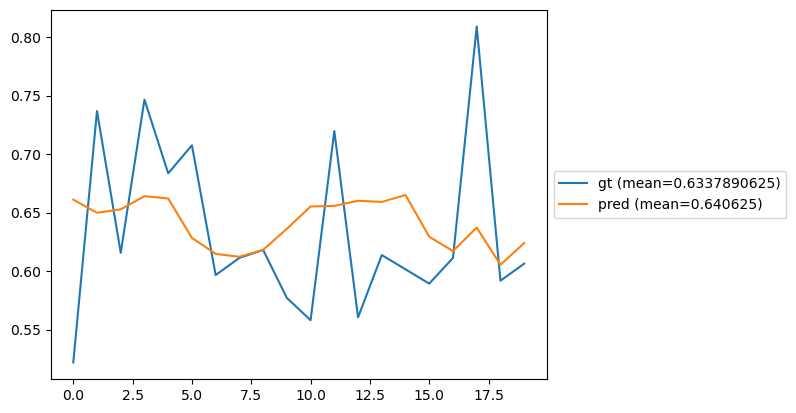

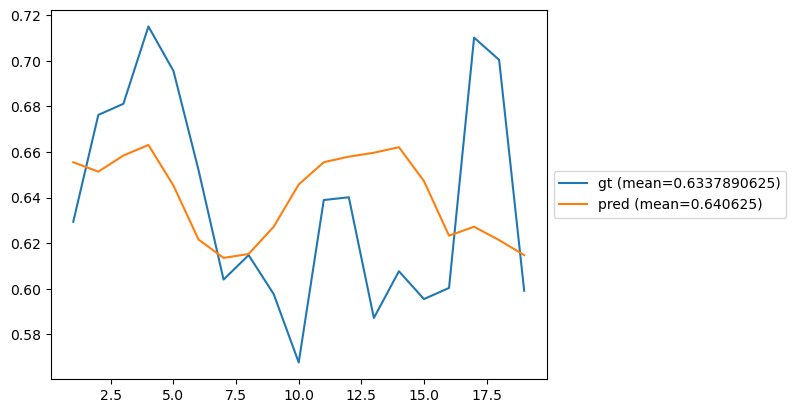

In [2997]:
"""
HCP
- 26, 56, 60 
- 22, 54, 61
- 22, 54, 60 
- 21, 55, 61 
- 25, 29, 62 
- 25, 30, 64
- 21, 55, 59
- 73, 59, 42
- 23, 47, 60
- 62, 80, 40

UKB
- 24, 70, 48 
- 44, 67, 60 
- 43, 61, 60
- 24, 67, 42 
- 21, 50, 61 
- 21, 51, 61
- 77, 49, 48
- 67, 77, 48 
"""

coord_x, coord_y, coord_z = 62, 80, 40  #HCP:   #UKB: 

time_window = 2


labels =  [f'gt (mean={np.mean(img_subj[0,coord_x,coord_y,coord_z,:])})', f'pred (mean={np.mean(pred_subj[0,coord_x,coord_y,coord_z,:])})', f'diff (mean={np.mean(diff_subj[0,coord_x,coord_y,coord_z,:])})']



def sagittal_view(time_point,transparency): 
    plt.figure()
    plt.plot([coord_z], [coord_y], 'bo', markersize=6)
    plt.imshow(img_subj[0,coord_x,:,:,time_point], cmap='gray')
    #plt.imshow(pred_subj[0,coord_x,:,:,time_point], cmap='Reds')
    plt.imshow(diff_subj[0,coord_x,:,:,time_point], cmap='Reds', alpha=transparency*0.01, vmin=vmin, vmax=0.05*vmax)
    #plt.imshow(masked_diff_subj[0,coord_x,:,:,time_point], cmap='Reds', alpha=transparency*0.01, vmin=vmin, vmax=0.05*vmax)
    plt.colorbar()
    plt.show()


def horizontal_view(time_point,transparency):
    plt.figure()
    plt.plot([coord_y], [coord_x],  'bo', markersize=6)
    plt.imshow(img_subj[0,:,:,coord_z,time_point], cmap='gray')
    #plt.imshow(pred_subj[0,:,:,coord_z,time_point], cmap='Reds')
    plt.imshow(diff_subj[0,:,:,coord_z,time_point], cmap='Reds', alpha=transparency*0.01, vmin=vmin, vmax=0.05*vmax)
    #plt.imshow(masked_diff_subj[0,:,:,coord_z,time_point], cmap='Reds', alpha=transparency*0.01, vmin=vmin, vmax=0.05*vmax)
    plt.colorbar()
    plt.show()


def coronal_view(time_point,transparency): 
    plt.figure()
    plt.plot([coord_z], [coord_x], 'bo', markersize=6)
    plt.imshow(img_subj[0,:,coord_y,:,time_point], cmap='gray')
    #plt.imshow(pred_subj[0,:,coord_y,:,time_point], cmap='Reds')
    plt.imshow(diff_subj[0,:,coord_y,:,time_point], cmap='Reds', alpha=transparency*0.01, vmin=vmin, vmax=0.05*vmax)
    #plt.imshow(masked_diff_subj[0,:,coord_y,:,time_point], cmap='Reds', alpha=transparency*0.01, vmin=vmin, vmax=0.05*vmax)
    plt.colorbar()
    plt.show()

# location in the brain
interact(sagittal_view, time_point=(0,t_max-1), transparency=(0,100))
interact(horizontal_view, time_point=(0,t_max-1), transparency=(0,100))
interact(coronal_view, time_point=(0,t_max-1), transparency=(0,100))

# plot
plt.close()
plt.figure()
plt.plot(img_subj[0,coord_x,coord_y,coord_z,:], label=labels[0])
plt.plot(pred_subj[0,coord_x,coord_y,coord_z,:], label=labels[1])
#plt.plot(diff_subj[0,time_point,y,z,:], label=labels[2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()





# plot
img_subj_coord = img_subj[0,coord_x, coord_y, coord_z,:]
pred_subj_coord = pred_subj[0,coord_x, coord_y, coord_z,:]

plt.figure()
plt.plot(pd.Series(img_subj_coord).rolling(window=time_window).mean(), label=labels[0])
plt.plot(pd.Series(pred_subj_coord).rolling(window=time_window).mean(), label=labels[1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



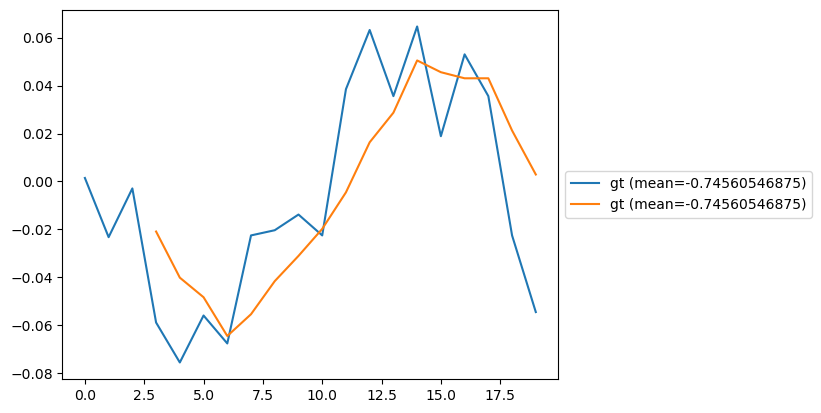

In [2975]:

coord_x, coord_y, coord_z = 30, 30, 30

time_window=4
plt.figure()
plt.plot(img_subj[0,coord_x,coord_y,coord_z,:], label=labels[0])
plt.plot(pd.Series(img_subj[0,coord_x, coord_y, coord_z,:]).rolling(window=time_window).mean(), label=labels[0])
#plt.plot(diff_subj[0,time_point,y,z,:], label=labels[2])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



interactive(children=(IntSlider(value=9, description='x', max=19), Output()), _dom_classes=('widget-interact',…

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


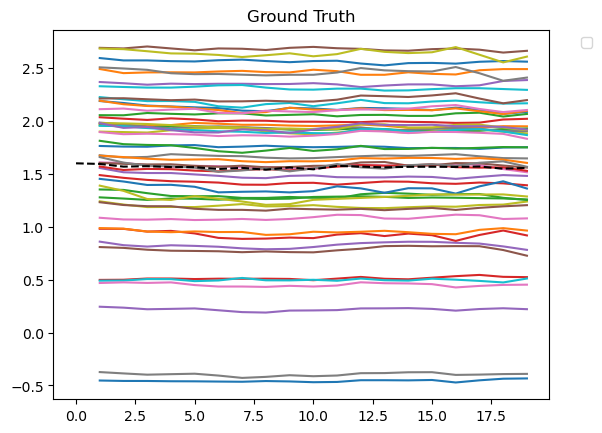

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


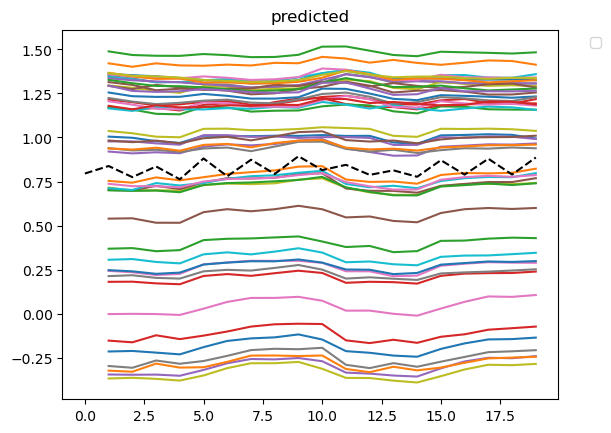

In [2979]:
import itertools
interval = 7
coord_x, coord_y, coord_z = 48, 90, 48 #0.002
time_window = 2





#### visualize location
count = 0 
coord = [[], []]
for a, b in itertools.product(range(interval), range(interval)):
    count += 1 
    tmp_a, tmp_b = a-(interval//2), b-(interval//2)
    tmp_a, tmp_b = coord_x+tmp_a, coord_y+tmp_b
    coord[0].append(tmp_a)
    coord[1].append(tmp_b)
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")

def temporal_view(x,):
    plt.figure()
    plt.imshow(img_subj[0,:,:,coord_z,x], cmap='gray')
    plt.plot(coord[1], coord[0], 'bo', markersize=3)
    #plt.imshow(pred_subj[0,:,:,coord_z,x], cmap='gray')
    #plt.imshow(diff_subj[0,:,:,coord_z,x], cmap='Reds', vmin=vmin, vmax=vmax)
    #plt.imshow(masked_img_subj[0,:,:,coord_z,x], cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

interact(temporal_view, x=(0,t_max-1))





#### visualize ground truth
plt.figure()
labels = [] 
# ground truth
count = 0 
labels.append(f'gt (x={coord_x}, y={coord_y}, z={coord_z})')
mean_value = [] 
#plt.plot(img_subj[0,coord_x,coord_y,coord_z,:], label=labels[count], linestyle='dashed')

# predicted
for a, b in itertools.product(range(interval), range(interval)):
    tmp_a, tmp_b = a-(interval//2), b-(interval//2)
    tmp_a, tmp_b = coord_x+tmp_a, coord_y+tmp_b
    labels.append(f'gt{count} (x={tmp_a}, y={tmp_b}, z={coord_z})')
    mean_value.append(np.expand_dims(img_subj[0,tmp_a,tmp_b,coord_z,:], axis=0))
    plt.plot(pd.Series(img_subj[0,tmp_a,tmp_b,coord_z,:]).rolling(window=time_window).mean()
                    #, label=labels[count]
                        )
    count += 1 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
mean_value = np.mean(np.vstack(mean_value), axis=0)
plt.plot(mean_value, 'k',linestyle='dashed')
plt.title('Ground Truth')
plt.show()






#### visualize predicted 
plt.figure()
labels = [] 

# ground truth
count = 0 
labels.append(f'gt (x={coord_x}, y={coord_y}, z={coord_z})')
mean_value = [] 
#plt.plot(img_subj[0,coord_x,coord_y,coord_z,:], label=labels[count], linestyle='dashed')

# predicted
for a, b in itertools.product(range(interval), range(interval)):
    tmp_a, tmp_b = a-(interval//2), b-(interval//2)
    tmp_a, tmp_b = coord_x+tmp_a, coord_y+tmp_b
    labels.append(f'pred{count} (x={tmp_a}, y={tmp_b}, z={coord_z})')
    mean_value.append(np.expand_dims(pred_subj[0,tmp_a,tmp_b,coord_z,:], axis=0))
    plt.plot(pd.Series(pred_subj[0,tmp_a,tmp_b,coord_z,:]).rolling(window=time_window).mean(), 
            #label=labels[count]
            )
    count += 1 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
mean_value = np.mean(np.vstack(mean_value), axis=0)
plt.plot(mean_value, 'k',linestyle='dashed')
plt.title("predicted")
plt.show()

In [551]:
import glob
import torch

subj_dir = '/Users/wangheehwan/Desktop/mim_pred_sample2/1590045_20227_2_0'
files = glob.glob(os.path.join(subj_dir, '*'))
frames_all = [] 
for i in range(len(files) - 1): 
    frame = torch.load(os.path.join(subj_dir, f'frame_{i}.pt'))
    frames_all.append(frame)

frames_all = torch.cat(frames_all, dim=-1)

stats = torch.load(os.path.join(subj_dir,"global_stats.pt"))
global_mean = stats['global_mean']
global_std = stats['global_std']
global_min = torch.min(frames_all)
global_max = stats['global_max']


In [552]:
scaling = 'minmax' # znorm, minmax

if scaling == 'znorm': 
    frames_all_scaled = ((frames_all - global_mean) / global_std).numpy()
elif scaling == 'minmax': 
    frames_all_scaled = ((frames_all - global_min) / (global_max - global_min)).numpy()

interactive(children=(IntSlider(value=15, description='x', max=31), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=15, description='x', max=31), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=15, description='x', max=31), Output()), _dom_classes=('widget-interact'…

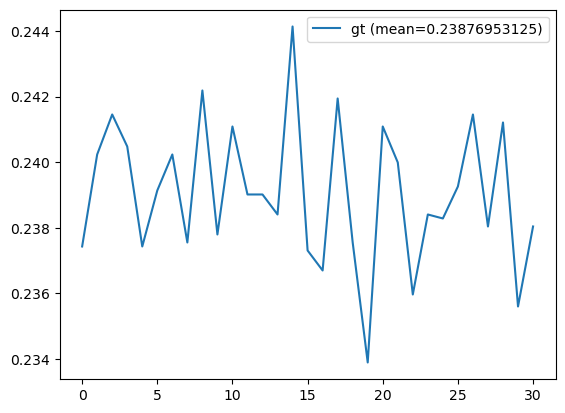

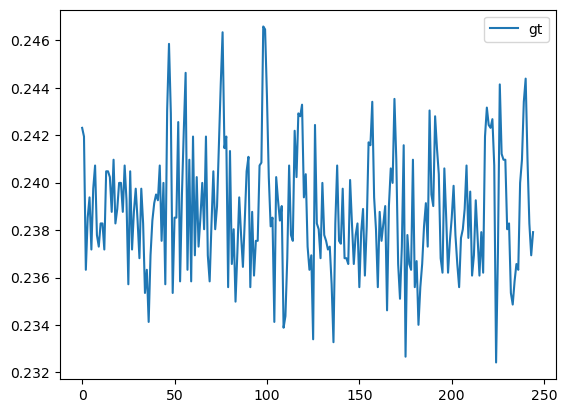

In [574]:
"""
Candidates 
- 14, 50, 45
- 30, 60, 22
- 40, 40, 83
- 60, 20, 19
- 80, 48, 40
- 80, 48, 60
- 80, 49, 48
- 56, 55, 80
- 50, 84, 35
- 51, 70, 40 
"""

coord_x, coord_y, coord_z = 60, 80, 30

time_interval = 2
t_max = 32
stride_point = 2
#t_max = frames_all_scaled.shape[-1]



labels =  [f'gt (mean={np.mean(frames_all_scaled[coord_x,coord_y,coord_z,:])})', f'pred (mean={np.mean(pred_subj[0,coord_x,coord_y,coord_z,:])})', f'diff (mean={np.mean(diff_subj[0,coord_x,coord_y,coord_z,:])})']

def sagittal_view(x,): 
    plt.figure()
    plt.imshow(frames_all_scaled[coord_x,:,:,x], cmap='gray')
    plt.plot([coord_z], [coord_y], 'bo', markersize=6)
    #plt.imshow(pred_subj[0,coord_x,:,:,x], cmap='Reds')
    #plt.imshow(diff_subj[0,coord_x,:,:,x], cmap='Reds', vmin=vmin, vmax=0.1)
    #plt.imshow(masked_diff_subj[0,coord_x,:,:,x], cmap='Reds', vmin=vmin, vmax=0.1)
    plt.colorbar()
    plt.show()


def horizontal_view(x,):
    plt.figure()
    plt.imshow(frames_all_scaled[:,:,coord_z,x], cmap='gray')
    plt.plot([coord_y], [coord_x],  'bo', markersize=6)
    #plt.imshow(pred_subj[0,:,:,coord_z,x], cmap='Reds')
    #plt.imshow(diff_subj[0,:,:,coord_z,x], cmap='Reds', vmin=vmin, vmax=0.1)
    #plt.imshow(masked_diff_subj[0,:,:,coord_z,x], cmap='Reds', vmin=vmin, vmax=0.1)
    plt.colorbar()
    plt.show()


def coronal_view(x,): 
    plt.figure()
    plt.imshow(frames_all_scaled[:,coord_y,:,x], cmap='gray')
    plt.plot([coord_z], [coord_x], 'bo', markersize=6)
    #plt.imshow(pred_subj[0,:,coord_y,:,x], cmap='Reds')
    #plt.imshow(diff_subj[0,:,coord_y,:,x], cmap='Reds', vmin=vmin, vmax=0.1)
    #plt.imshow(masked_diff_subj[0,:,coord_y,:,x], cmap='Reds', vmin=vmin, vmax=0.1)
    plt.colorbar()
    plt.show()

# location in the brain
interact(sagittal_view, x=(0,t_max-1))
interact(horizontal_view, x=(0,t_max-1))
interact(coronal_view, x=(0,t_max-1))

# plot
plt.close()
plt.figure()
plt.plot(frames_all_scaled[coord_x,coord_y,coord_z, (stride_point-1)*t_max:stride_point*t_max-1], label=labels[0])
#plt.plot(diff_subj[0,x,y,z,:], label=labels[2])
plt.legend(loc='upper right')
plt.show()





# plot
frames_all_scaled_coord = frames_all_scaled[coord_x, coord_y, coord_z,:]

new_img = []
for i in range(int(frames_all_scaled.shape[-1]//time_interval)): 
    time_range_img = []
    for t in range(time_interval): 
        tp = 2*i + t
        time_range_img.append(frames_all_scaled_coord[tp])
    new_img.append(np.mean(time_range_img))    
plt.figure()
plt.plot(new_img, label='gt')

plt.legend(loc='upper right')
plt.show()


In [426]:
import os 
import shutil
import imageio

tmp_work_dir = '/Users/wangheehwan/Desktop/tmp_gif'
gif_file = '/Users/wangheehwan/Desktop/simmim_pred_HBN_seq20_timepatch1_masking0.8.gif'

# make temporal working directory
if os.path.isdir(tmp_work_dir) is False:
    os.mkdir(tmp_work_dir) 

# stack 2D slices 
gif_np = [pred_subj[0,:,:,48,x] for x in range(t_max)]

# save array as plot png
file_names = []
for i in range(len(gif_np)): 
    file_name = os.path.join(tmp_work_dir,f'simmim_pred_HBN_seq20_timepatch1_masking0.8_t{i}.png')
    file_names.append(file_name)
    plt.imshow(pred_subj[0,:,:,48,i], cmap='Reds')
    plt.savefig(file_name)
    plt.close()

# load plot png
frames = []
for file_name in file_names:
    if file_name.endswith(".png"):
        frames.append(imageio.imread(file_name))

# make gif
imageio.mimsave(gif_file, frames, format='GIF', duration=1)

# remove intermediate files (plot png)
for file_name in set(file_names):
    os.remove(file_name)

# remove temporal working directory
if os.path.isdir(tmp_work_dir) is False:
    shutil.rmtree(tmp_work_dir)

IndexError: index 32 is out of bounds for axis 4 with size 32

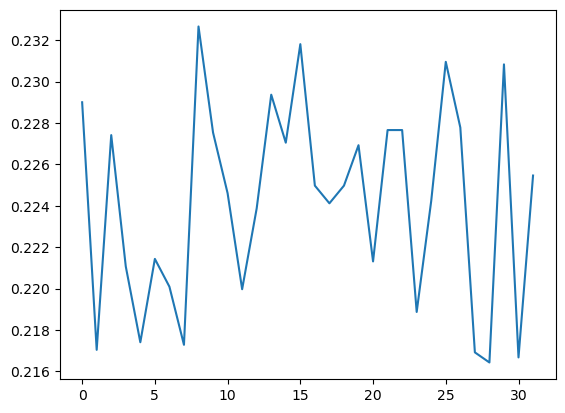

In [3240]:
time_interval = 1 
coord_x, coord_y, coord_z = 80, 48, 40
img_subj_coord = img_subj[0,coord_x, coord_y, coord_z,:]

new = [] 
for i in range(int(img_subj.shape[-1]//time_interval)): 
    time_range = [] 
    for t in range(time_interval): 
        tp = i + t
        time_range.append(img_subj_coord[tp])
    new.append(np.mean(time_range))

plt.plot(new)

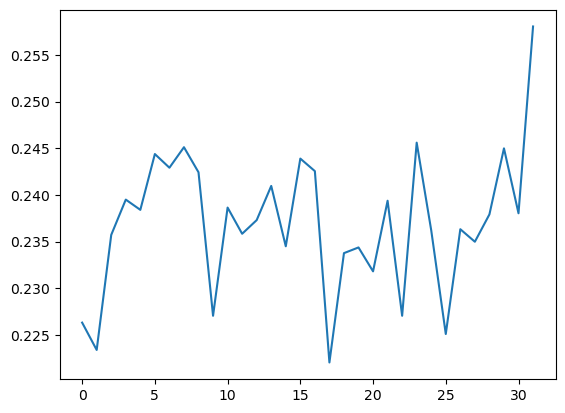

In [3241]:
time_interval = 1 
coord_x, coord_y, coord_z = 80, 48, 40
img_subj_coord = pred_subj[0,coord_x, coord_y, coord_z,:]

new = [] 
for i in range(int(img_subj.shape[-1]//time_interval)): 
    time_range = [] 
    for t in range(time_interval): 
        tp = i + t
        time_range.append(img_subj_coord[tp])
    new.append(np.mean(time_range))

plt.plot(new)

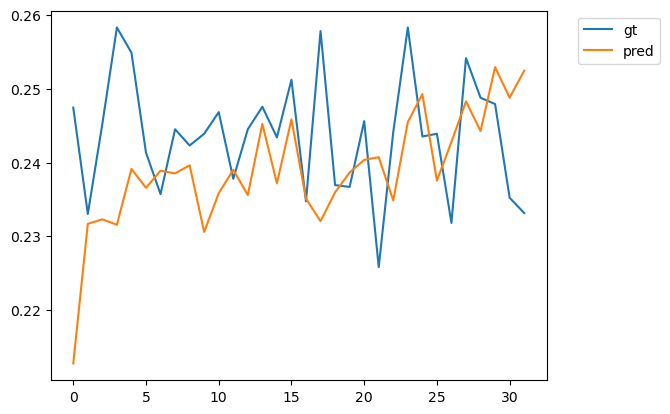

In [3269]:
time_interval = 1 
coord_x, coord_y, coord_z = 80, 49, 48
img_subj_coord = img_subj[0,coord_x, coord_y, coord_z,:]
pred_subj_coord = pred_subj[0,coord_x, coord_y, coord_z,:]

new_img = []
new_pred = [] 
for i in range(int(img_subj.shape[-1]//time_interval)): 
    time_range_img = []
    time_range_pred = [] 
    for t in range(time_interval): 
        tp = i + t
        time_range_img.append(img_subj_coord[tp])
        time_range_pred.append(pred_subj_coord[tp])
    new_img.append(np.mean(time_range_img))    
    new_pred.append(np.mean(time_range_pred))
plt.figure()
plt.plot(new_img, label='gt')

plt.plot(new_pred, label='pred')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()

In [52]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact 


subj = 3
time = 29

img = np.load('/Users/wangheehwan/Desktop/ummae_img.npy')
pred = np.load('/Users/wangheehwan/Desktop/ummae_pred.npy')

img_subj = img[subj]
pred_subj = pred[subj]
#mask_subj = 1 - mask[subj]
diff_subj = np.abs(img_subj - pred_subj) 
#masked_diff_subj = mask_subj * diff_subj

vmin = np.min(diff_subj)
vmax = np.max(diff_subj)



def sagittal_view(x,): 
    plt.figure()
    #plt.imshow(img_subj[0,x,:,:,time], cmap='gray')
    plt.imshow(pred_subj[0,x,:,:,time], alpha=0.6)
    #plt.imshow(diff_subj[0,x,:,:,time], cmap='Reds', vmin=vmin, vmax=vmax)
    #plt.imshow(masked_diff_subj[0,x,:,:,time], cmap='Reds', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

def coronal_view(x,): 
    plt.figure()
    #plt.imshow(img_subj[0,:,:,x,time], cmap='gray')
    plt.imshow(pred_subj[0,:,:,x,time], alpha=0.6)
    #plt.imshow(diff_subj[0,:,:,x,time], cmap='Reds', vmin=vmin, vmax=vmax)
    #plt.imshow(masked_diff_subj[0,x,:,:,time], cmap='Reds', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

def horizontal_view(x,): 
    plt.figure()
    #plt.imshow(img_subj[0,:,x,:,time], cmap='gray')
    plt.imshow(pred_subj[0,:,x,:,time], alpha=0.6)
    #plt.imshow(diff_subj[0,:,x,:,time], cmap='Reds', vmin=vmin, vmax=vmax)
    #plt.imshow(masked_diff_subj[0,x,:,:,time], cmap='Reds', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()
print(f'Loss: {np.mean(diff_subj)}')

interact(sagittal_view, x=(0,95))
interact(coronal_view, x=(0,95))
interact(horizontal_view, x=(0,95))

Loss: 2.2222235202789307


interactive(children=(IntSlider(value=47, description='x', max=95), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=47, description='x', max=95), Output()), _dom_classes=('widget-interact'…

interactive(children=(IntSlider(value=47, description='x', max=95), Output()), _dom_classes=('widget-interact'…

<function __main__.horizontal_view(x)>

In [1109]:
import pandas as pd
pheno = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/ABCD_phenotype_total_for_pretraining_1y_after_become_overweight_10PS_stratified_5fold.csv')
ksad_parent = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/release5.1/mental-health/mh_p_ksads_ss.csv')
ksad_youth = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/release5.1/mental-health/mh_y_ksads_ss.csv')

/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_2130/2113492055.py:3: DtypeWarning: Columns (2,955,1909,1910) have mixed types. Specify dtype option on import or set low_memory=False.
  ksad_parent = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/release5.1/mental-health/mh_p_ksads_ss.csv')
/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_2130/2113492055.py:4: DtypeWarning: Columns (2,956,1286,1287) have mixed types. Specify dtype option on import or set low_memory=False.
  ksad_youth = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/release5.1/mental-health/mh_y_ksads_ss.csv')


In [1131]:
"""
'ksads_1_840_p': Diagnosis - Major Depressive Disorder Present
'ksads_1_842_p': Diagnosis - Major Depressive Disorder Past (F32.9)

'ksads_8_863_p': Diagnosis - Social Anxiety Disorder (F40.10) PRESENT
'ksads_8_864_p': Diagnosis - Social Anxiety Disorder (F40.10) PAST

'ksads_10_869_p': Diagnosis - Generalized Anxiety Disorder Present (F41.1)	
'ksads_10_870_p': Diagnosis - Generalized Anxiety Disorder PAST (F41.1)
"""

ksad_summ_parent = ksad_parent[['src_subject_id', 'eventname', 'ksads_1_840_p', 'ksads_1_842_p','ksads_8_863_p', 'ksads_8_864_p','ksads_10_869_p', 'ksads_10_870_p']]
ksad_summ_parent = ksad_summ_parent[ksad_summ_parent['eventname'] == 'baseline_year_1_arm_1']
for i in range(len(ksad_summ_parent)):
    ksad_summ_parent['src_subject_id'].values[i] = ksad_summ_parent['src_subject_id'].values[i].replace("_", "")
ksad_summ_parent.columns = ['subjectkey', 'eventname','MDD_parent_present', 'MDD_parent_past', 'SAD_parent_present', 'SAD_parent_past', 'GAD_parent_present', 'GAD_parent_past']
ksad_summ_parent = ksad_summ_parent.drop(columns='eventname')

In [1132]:
"""
'ksads_1_840_t': Diagnosis - Major Depressive Disorder Present
'ksads_1_842_t': Diagnosis - Major Depressive Disorder Past (F32.9)

'ksads_8_863_t': Diagnosis - Social Anxiety Disorder (F40.10) PRESENT
'ksads_8_864_t': Diagnosis - Social Anxiety Disorder (F40.10) PAST

'ksads_10_869_t': Diagnosis - Generalized Anxiety Disorder Present (F41.1)	
'ksads_10_870_t': Diagnosis - Generalized Anxiety Disorder PAST (F41.1)
"""

ksad_summ_youth = ksad_youth[['src_subject_id', 'eventname', 'ksads_1_840_t', 'ksads_1_842_t','ksads_8_863_t', 'ksads_8_864_t','ksads_10_869_t', 'ksads_10_870_t']]
ksad_summ_youth = ksad_summ_youth[ksad_summ_youth['eventname'] == 'baseline_year_1_arm_1']
for i in range(len(ksad_summ_youth)):
    ksad_summ_youth['src_subject_id'].values[i] = ksad_summ_youth['src_subject_id'].values[i].replace("_", "")
ksad_summ_youth.columns = ['subjectkey', 'eventname','MDD_youth_present', 'MDD_youth_past', 'SAD_youth_present', 'SAD_youth_past', 'GAD_youth_present', 'GAD_youth_past']
ksad_summ_youth = ksad_summ_youth.drop(columns='eventname')

In [1137]:
ksad_summ_all = pd.merge(ksad_summ_parent, ksad_summ_youth, how='inner', on='subjectkey')
pheno_new = pd.merge(pheno, ksad_summ_all, how='inner', on='subjectkey')

In [1139]:
pheno_new.to_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/mh_finetuning/ABCD_phenotype_total_for_pretraining_1y_after_become_overweight_10PS_stratified_5fold.csv', index=False)

In [1163]:
len(pheno_new[pheno_new['GAD_parent_past']==1])

428

In [1161]:
len(pheno_new[(pheno_new['Generalized.Anxiety.Disorder.x']==1) & (pheno_new['GAD_parent_past']==1)])

428

In [33]:
mask.shape

(91, 109, 91)

In [48]:
padded_video.shape

(91, 96, 91, 588)

In [67]:
img = nib.load('/Users/wangheehwan/Desktop/swift_data/704/704.sess1.Rest1.tproject+tlrc_processed.nii.gz')
img = img.get_fdata()[:, 6:102, :, :]
#mask = nib.load('/Users/wangheehwan/Desktop/swift_data/run1_1/704/MNI152_T1_2mm_brain_mask.nii.gz')
#mask = mask.get_fdata()[:, 6:102, :]

padded_video = img

time = 3
s_max = padded_video.shape[0]
h_max = padded_video.shape[2]
c_max = padded_video.shape[1]


padded_video = (padded_video >= 0 ) * padded_video

def sagittal_view(slice,transparency): 
    plt.figure()
    #plt.imshow(img_subj[slice,:,:,time], cmap='gray')
    plt.imshow(padded_video[slice,:,:,time], cmap='gray')
    #plt.imshow(mask[slice,:,:], cmap='Reds',  alpha=transparency*0.01)
    #plt.imshow(padded_video_masking[slice,:,:,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()

def horizontal_view(slice,transparency): 
    plt.figure()
    #plt.imshow(img_subj[:,:,slice,time], cmap='gray')
    plt.imshow(padded_video[:,:,slice,time], cmap='gray')
    #plt.imshow(mask[:,:,slice], cmap='Reds',  alpha=transparency*0.01)
    #plt.imshow(padded_video_masking[:,:,slice,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,:,:,slice,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()

def coronal_view(slice,transparency): 
    plt.figure()
    #plt.imshow(img_subj[:,slice,:,time], cmap='gray')
    plt.imshow(padded_video[:,slice,:,time], cmap='gray')
    #plt.imshow(mask[:,slice,:], cmap='Reds',  alpha=transparency*0.01)
    #plt.imshow(padded_video_masking[:,slice,:,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,:,slice,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()



interact(sagittal_view, slice=(0,s_max-1), transparency=(0,100))
interact(horizontal_view, slice=(0,h_max-1), transparency=(0,100))
interact(coronal_view, slice=(0,c_max-1), transparency=(0,100))

interactive(children=(IntSlider(value=45, description='slice', max=90), IntSlider(value=50, description='trans…

interactive(children=(IntSlider(value=45, description='slice', max=90), IntSlider(value=50, description='trans…

interactive(children=(IntSlider(value=47, description='slice', max=95), IntSlider(value=50, description='trans…

<function __main__.coronal_view(slice, transparency)>

In [90]:
img = torch.load('/Users/wangheehwan/Desktop/swift_data/frame_1.pt')    # YooAttn 
mask = torch.load('/Users/wangheehwan/Desktop/swift_data/frame_0.pt')   #UKB
#mask = nib.load('/Users/wangheehwan/Desktop/swift_data/run1_1/704/MNI152_T1_2mm_brain_mask.nii.gz')
#mask = mask.get_fdata()[:, 6:102, :]
img = torch.nn.functional.pad(img.squeeze(-1).unsqueeze(0), (2,3, 0, 0, 2, 3), value=mask.flatten()[0]).squeeze(0)
mask = torch.nn.functional.pad(mask.squeeze(-1).unsqueeze(0), (3, 9, 0, 0, 10, 8), value=mask.flatten()[0]).squeeze(0)


padded_video = img

s_max = padded_video.shape[0]
h_max = padded_video.shape[2]
c_max = padded_video.shape[1]


#padded_video = (padded_video >= 0 ) * padded_video

def sagittal_view(slice,transparency): 
    plt.figure()
    #plt.imshow(img_subj[slice,:,:,time], cmap='gray')
    plt.imshow(padded_video[slice,:,:], cmap='gray')
    plt.imshow(mask[slice,:,:], cmap='Reds',  alpha=transparency*0.01)
    #plt.imshow(padded_video_masking[slice,:,:,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()

def horizontal_view(slice,transparency): 
    plt.figure()
    #plt.imshow(img_subj[:,:,slice,time], cmap='gray')
    plt.imshow(padded_video[:,:,slice], cmap='gray')
    plt.imshow(mask[:,:,slice], cmap='Reds',  alpha=transparency*0.01)
    #plt.imshow(padded_video_masking[:,:,slice,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,:,:,slice,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()

def coronal_view(slice,transparency): 
    plt.figure()
    #plt.imshow(img_subj[:,slice,:,time], cmap='gray')
    plt.imshow(padded_video[:,slice,:], cmap='gray')
    plt.imshow(mask[:,slice,:], cmap='Reds',  alpha=transparency*0.01)
    #plt.imshow(padded_video_masking[:,slice,:,time], cmap='Reds', alpha=transparency*0.01)
    #plt.imshow(diff_subj[0,:,slice,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    #plt.imshow(masked_diff_subj[0,slice,:,:,time], cmap='Reds', vmin=vmin, vmax=0.05*vmax, alpha=transparency*0.01)
    plt.colorbar()
    plt.show()



interact(sagittal_view, slice=(0,s_max-1), transparency=(0,100))
interact(horizontal_view, slice=(0,h_max-1), transparency=(0,100))
interact(coronal_view, slice=(0,c_max-1), transparency=(0,100))

interactive(children=(IntSlider(value=47, description='slice', max=95), IntSlider(value=50, description='trans…

interactive(children=(IntSlider(value=47, description='slice', max=95), IntSlider(value=50, description='trans…

interactive(children=(IntSlider(value=47, description='slice', max=95), IntSlider(value=50, description='trans…

<function __main__.coronal_view(slice, transparency)>

In [73]:
img = torch.load('/Users/wangheehwan/Desktop/swift_data/frame_1.pt')    # YooAttn 
mask = torch.load('/Users/wangheehwan/Desktop/swift_data/frame_0.pt')   #UKB

In [86]:
torch.nn.functional.pad(mask.squeeze(-1).unsqueeze(0), (3, 9, 0, 0, 10, 8), value=mask.flatten()[0]).shape

torch.Size([1, 96, 96, 96])

In [88]:
torch.nn.functional.pad(img.squeeze(-1).unsqueeze(0), (2,3, 0, 0, 2, 3), value=mask.flatten()[0]).shape

torch.Size([1, 96, 96, 96])